环境导入

In [1]:
import sys
package_root = r"F:\onedrive\vs experiment\transmon-qubit"

sys.path.insert(0, package_root)
print(sys.executable)
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

fig_path = Path.cwd() / 'figures'

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import matplotlib
import numpy as np
import qutip as qp
from qutip import *
from qutip import about, basis, destroy, mesolve, ptrace, qeye, tensor, wigner, Qobj
import matplotlib as mpl
import scipy
from sklearn.metrics import mean_squared_error
from scipy.optimize import least_squares, curve_fit
from scipy.signal import find_peaks
import copy
from chip_hamiltonian.chip_hamiltonian import Chip, ChipDynamic
from solvers.solvers import Solver, SolverDynamic
from experiment import *
from pulse.pulse_lib import *
from functions.plot_tools import PlotTool
from functions.fit_tools import fit_fft
from functions import *
from functions.tools import *
from scipy.optimize import *
from itertools import product
from joblib import Parallel, delayed
import time

from multiprocessing import Pool, cpu_count

# %matplotlib notebook
%matplotlib inline
np.set_printoptions(threshold=np.inf, precision=7, suppress=True)

font = {'family': 'Helvetica', 'weight': 'bold', 'size': 15}
ploter = PlotTool(figsize=(8, 5), cmap='jet', flag_save=True)

D:\anaconda\anaconda\python.exe


In [2]:
# 读写数据

def write_data(f, data):
    with open(f, 'w') as fp:
        for d in data:
            fp.write(str(d) + '\n')

def read_data(f):
    with open(f, 'r') as fp:
        data = fp.read()
        data = data.split('\n')
        if '' in data:
            data.remove('')
    f = []
    for d in data:
        if '(' in d:
            d = d[1:-2]
        f.append(float(d))
    return f


C:\Users\KUSANA~1\AppData\Local\Temp/ipykernel_27848/3356045173.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(X,


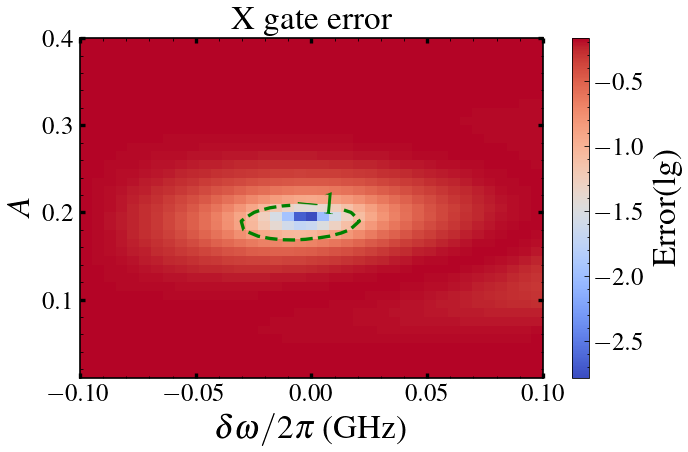

In [3]:
# 单比特门
anharm = {'q0' : -220 * 1e-3, 'c0' : -200 * 1e-3, 'q1' : -220 * 1e-3, 'c1' : -200 * 1e-3, 'q2' : -220 * 1e-3}
omega = 4.5
bitNum = 1
energyLevel = 3
tg = 30

# 单比特门参数空间

detuneLow, detuneHigh = -0.1, 0.1
detunes = np.linspace(detuneLow, detuneHigh, 40)
ampLow, ampHigh = 0.01, 0.4
amps = np.linspace(ampLow, ampHigh, 40)

err_list = np.array(read_data(Path.cwd() / 'figures' / 'X_gate_err.txt')).reshape([40, 40])

X, Y = np.meshgrid(detunes, amps)
fig, ax = plt.subplots(figsize=(6, 4))
norm = mpl.colors.LogNorm()
c = ax.pcolormesh(X,
                  Y,
                  np.log10(err_list),
                  cmap='coolwarm')

cb = plt.colorbar(c, ax=ax)
font = {'size': 20}
cb.set_label(rf'Error(lg)', fontdict=font)
ax.set_xlabel(r'$\delta\omega/2\pi$ (GHz)', fontdict=font)
ax.set_ylabel(r'$A$', fontdict=font)

# 画一个箭头：从点(0.5, 0.5)指向点(0.2, 0.2)
# ax.arrow(4.5058 - 4.4958, 5.1, -0.01, 0, head_width=0.014, head_length=0.003, fc='k', ec='k', width=0.0005)

# 在箭尾添加文字
# ax.text(4.5058 - 4.4958, 5.1, r'$\omega_{h}+\eta_h-\omega_{l}=0$ GHz', style='italic', fontsize=12)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='both', which='major', width=2)  # 主刻度

cb.ax.tick_params(labelsize=15)
spines = ax.spines

# 设置四个边框线的宽度
for spine in spines.values():
    spine.set_linewidth(1.)  # 设置线宽为2

CS = ax.contour(X, Y, np.log10(err_list), levels=[-1], colors='green', linewidths=2)  # 10 条等高线，黑色
ax.clabel(CS, inline=True, fontsize=20)
ax.set_title(r'X gate error', fontdict=font)
plt.tight_layout()
# ploter.save_fig(fig, rf'cz cali', flag_save=True)
plt.savefig(os.path.join(fig_path, rf'X gate error.pdf'))

载入$|Q_LC_{LH}Q_HC_{HS}Q_S\rangle$的参数

In [4]:
yaml_path_3q = r'F:\OneDrive\vs experiment\freqalloc_tsq\chip_param_3q.yaml'
yaml_path_2q = r'F:\OneDrive\vs experiment\freqalloc_tsq\chip_param_2q.yaml'

根据参数，求zz关断点位置，并写入到yaml文件中

In [5]:
chip = Solver(chip_path=yaml_path_3q, dim=3, flag_g_exact=True)
w_off, zz_off = chip.ZZ_min((5, 8), 'Q1', 'Q2', save_flag=True)
print(f'w_off: {w_off} GHz  zz_off: {zz_off * 1e6} kHz')
w_off, zz_off = chip.ZZ_min((5, 8), 'Q2', 'Q3', save_flag=True)
print(f'w_off: {w_off} GHz  zz_off: {zz_off * 1e6} kHz')

num_cpus: 20
w_off: 6.545139772618081 GHz  zz_off: 13.003158938040826 kHz
w_off: 6.535744096749549 GHz  zz_off: 13.762912231207736 kHz


In [6]:
# 假设 chip 对象已经定义
w3_list = np.linspace(chip.q_dic['Q1']['w_idle'] - 0.1, chip.q_dic['Q1']['w_idle'] + 0.1, 50)
wc_list = np.linspace(6, 7, 40)
zz = np.zeros((len(w3_list), len(wc_list)))

def compute_zz(i, j, w3, wc, chip):
    # 深拷贝 chip
    chipCopy = copy.deepcopy(chip)
    chipCopy.q_dic['Q3']['w_idle'] = w3
    chipCopy.q_dic['C2_3']['w_idle'] = wc
    chipCopy.q_dic['Q3']['w'] = w3
    chipCopy.q_dic['C2_3']['w'] = wc
    idle_eigen_exp = chip.idle_eigen(chipCopy.q_dic)

    ZZ = (
        idle_eigen_exp[
            chip.Ed(('Q2', 'Q3'), (1, 1), chipCopy.q_dic, state_flag=True)
        ]
        + idle_eigen_exp[
            chip.Ed(('Q2', 'Q3'), (0, 0), chipCopy.q_dic, state_flag=True)
        ]
        - idle_eigen_exp[
            chip.Ed(('Q2', 'Q3'), (0, 1), chipCopy.q_dic, state_flag=True)
        ]
        - idle_eigen_exp[
            chip.Ed(('Q2', 'Q3'), (1, 0), chipCopy.q_dic, state_flag=True)
        ]
    )
    return i, j, ZZ

# 并行计算
print('start')
results = Parallel(n_jobs=-1)(delayed(compute_zz)(i, j, w3, wc, chip)
                              for i, w3 in enumerate(w3_list)
                              for j, wc in enumerate(wc_list))

# 填充结果到 zz
for i, j, ZZ in results:
    zz[i, j] = ZZ
print('finish')

start
finish


C:\Users\KUSANA~1\AppData\Local\Temp/ipykernel_44024/816696663.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(X,


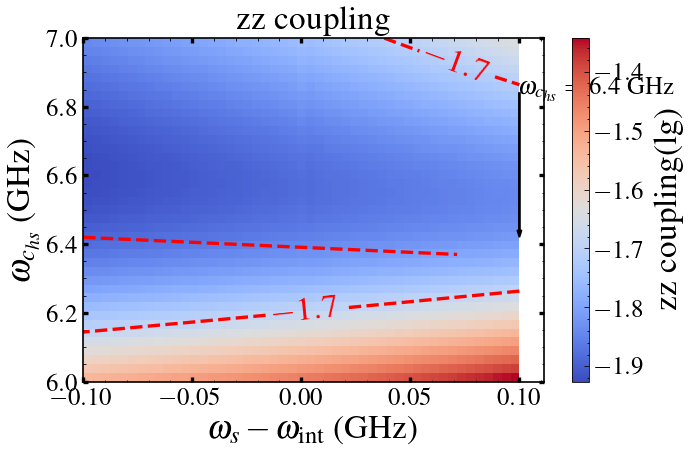

In [7]:
w3_list = np.linspace(-0.1, 0.1, 50)
wc_list = np.linspace(6, 7, 40)
X, Y = np.meshgrid(w3_list, wc_list)
fig, ax = plt.subplots(figsize=(6, 4))
norm = mpl.colors.LogNorm()
c = ax.pcolormesh(X,
                  Y,
                  np.log10(np.abs(zz.T) * 1e3),
                  cmap='coolwarm')

cb = plt.colorbar(c, ax=ax)
font = {'size': 20}
cb.set_label(rf'zz coupling(lg)', fontdict=font)
ax.set_xlabel(r'$\omega_{s} - \omega_\text{int}$ (GHz)', fontdict=font)
ax.set_ylabel(r'$\omega_{c_{hs}}$ (GHz)', fontdict=font)

# 画一个箭头：从点(0.5, 0.5)指向点(0.2, 0.2)
ax.arrow(4.2 - chip.q_dic['Q1']['w_idle'], 6.8401, 0, -0.4, head_width=0.002, head_length=0.02, fc='k', ec='k', width=0.0005)

# 在箭尾添加文字
ax.text(4.2 - chip.q_dic['Q1']['w_idle'], 6.8401, r'$\omega_{c_{hs}}=6.4$ GHz', style='italic', fontsize=15)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='both', which='major', width=2)  # 主刻度

cb.ax.tick_params(labelsize=15)
spines = ax.spines

# 设置四个边框线的宽度
for spine in spines.values():
    spine.set_linewidth(1.)  # 设置线宽为2

CS = ax.contour(X, Y, np.log10(np.abs(zz.T) * 1e3), levels=[-1.7], colors='red', linewidths=2, linestyles='dashed')
ax.clabel(CS, inline=True, fontsize=20)
ax.set_title(r'zz coupling', fontdict=font)
# plt.hlines(y=6.4, xmin=w3_list[0], xmax=w3_list[-8], colors='red', linestyles='dashed')
plt.plot([w3_list[0], w3_list[-8]], [6.42, 6.37], color='red', linewidth=2, linestyle='dashed')
plt.tight_layout()
output_path = Path.cwd() / 'figures' / "zz.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')

In [6]:
time_step = 0.2
sigma_q = 1.25
sigma_c = 2
buffer = 7.5
cz = CZ(chip_path=yaml_path_3q,
        dim=3,
        QL='Q1',
        QH='Q2',
        flag_fig=True,
        time_step=time_step,
        flag_data=False,
        flag_g_exact=True,
        num_cpus=20)
cz_2q = CZ(chip_path=yaml_path_2q,
            dim=[3, 3, 3],
            QL='Q1',
            QH='Q2',
            flag_fig=True,
            time_step=time_step,
            flag_data=False,
            flag_g_exact=True,
            num_cpus=20)
# plt.style.use('bmh')
exp_args = {
    'shape': 'FlattopGaussian',
    'arg_type': 'wq',
    'sigma_q': sigma_q,
    'sigma_c': sigma_c,
    'buffer': buffer,
    'fix_bit_arg': {
        'Q1': 4.294659000000001
    }
}
cz.exp_args = exp_args
cz_2q.exp_args = exp_args

num_cpus: 20
num_cpus: 20


CZ保真度与频率校准

In [7]:
w2_list = 4.4958 + np.linspace(-0.1, 0.1, 50)
wc_list = np.linspace(4.6, 5.5, 30)
arg_list_dic = {'C1_2': wc_list, 'Q2': w2_list}

In [8]:
# arg_list_dic
w_list = list(product(*arg_list_dic.values()))

error_list = qp.parallel_map(cz.fidelity_calculate,
                             w_list,
                             task_args=(list(arg_list_dic.keys()), 40),
                             progress_bar=True)

10.0%. Run time:  47.79s. Est. time left: 00:00:07:10
20.0%. Run time:  89.28s. Est. time left: 00:00:05:57
30.0%. Run time: 131.17s. Est. time left: 00:00:05:06
40.0%. Run time: 172.43s. Est. time left: 00:00:04:18
50.0%. Run time: 215.36s. Est. time left: 00:00:03:35
60.0%. Run time: 258.22s. Est. time left: 00:00:02:52
70.0%. Run time: 300.91s. Est. time left: 00:00:02:08
80.0%. Run time: 344.17s. Est. time left: 00:00:01:26
90.0%. Run time: 386.99s. Est. time left: 00:00:00:42
100.0%. Run time: 428.83s. Est. time left: 00:00:00:00
Total run time: 429.00s


C:\Users\KUSANA~1\AppData\Local\Temp/ipykernel_27848/1991583184.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(X,


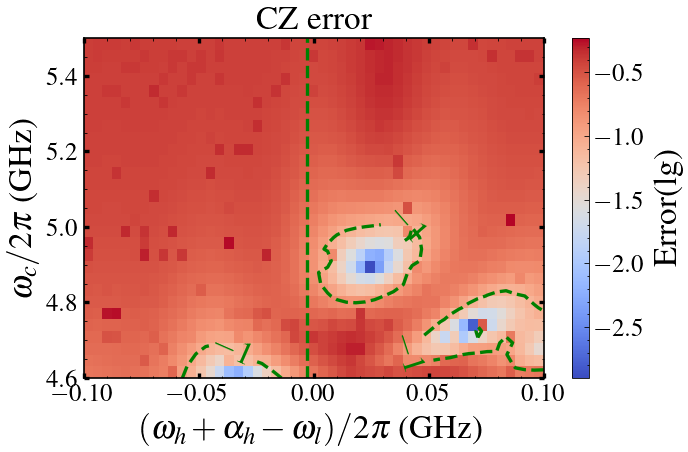

In [9]:
output_path = Path.cwd() / 'errList.txt'
error_list = read_data(output_path)

w2_list = np.linspace(-0.1, 0.1, 50)
wc_list = np.linspace(4.6, 5.5, 30)
error_arr = np.array(error_list).reshape(len(wc_list), len(w2_list))

X, Y = np.meshgrid(w2_list, wc_list)
fig, ax = plt.subplots(figsize=(6, 4))
norm = mpl.colors.LogNorm()
c = ax.pcolormesh(X,
                  Y,
                  np.log10(error_arr),
                  cmap='coolwarm')

cb = plt.colorbar(c, ax=ax)
font = {'size': 20}
cb.set_label(rf'Error(lg)', fontdict=font)
ax.set_xlabel(r'$(\omega_{h}+\alpha_h-\omega_{l})/2\pi$ (GHz)', fontdict=font)
ax.set_ylabel(r'$\omega_{c}/2\pi$ (GHz)', fontdict=font)

# 画一个箭头：从点(0.5, 0.5)指向点(0.2, 0.2)
# ax.arrow(4.5058 - 4.4958, 5.1, -0.01, 0, head_width=0.014, head_length=0.003, fc='k', ec='k', width=0.0005)

# 在箭尾添加文字
# ax.text(4.5058 - 4.4958, 5.1, r'$\omega_{h}+\eta_h-\omega_{l}=0$ GHz', style='italic', fontsize=12)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='both', which='major', width=2)  # 主刻度

cb.ax.tick_params(labelsize=15)
spines = ax.spines

# 设置四个边框线的宽度
for spine in spines.values():
    spine.set_linewidth(1.)  # 设置线宽为2

CS = ax.contour(X, Y, np.log10(error_arr), levels=[-1], colors='green', linewidths=2)  # 10 条等高线，黑色
ax.clabel(CS, inline=True, fontsize=20)
ax.set_title(r'CZ error', fontdict=font)
plt.vlines(x=4.493 - 4.4958, ymin=wc_list[0], ymax=wc_list[-1], colors='green', linestyles='dashed', linewidth=2)
plt.tight_layout()
# ploter.save_fig(fig, rf'cz cali', flag_save=True)
plt.savefig(os.path.join(fig_path, rf'cz_cali.pdf'))


前两个比特做CZ门，优化参数

In [52]:
bit_name_list = ['Q2', 'C1_2']
width = 40

# cz.fidelity_optimize(bit_name_list, width)
cz.fidelity_optimize(bit_name_list, width, w0_list=[4.519362614783559, 4.8886699367859645])

{'Q2': 4.519362614783559, 'C1_2': 4.8886699367859645} 0.0027547084767813868
{'Q2': 4.569362614783559, 'C1_2': 4.8886699367859645} 0.30393605418897207
{'Q2': 4.519362614783559, 'C1_2': 5.088669936785965} 0.25461940064273314
{'Q2': 4.4693626147835595, 'C1_2': 5.088669936785964} 0.3483211159896682
{'Q2': 4.544362614783559, 'C1_2': 4.938669936785964} 0.1105206442612362
{'Q2': 4.54436261478356, 'C1_2': 4.738669936785965} 0.1656120188316198
{'Q2': 4.538112614783559, 'C1_2': 4.8261699367859645} 0.1346985252337889
{'Q2': 4.52561261478356, 'C1_2': 5.001169936785965} 0.12967541731880083
{'Q2': 4.52873761478356, 'C1_2': 4.957419936785965} 0.06058476596391438
{'Q2': 4.50373761478356, 'C1_2': 4.907419936785966} 0.05998923941996959
{'Q2': 4.494362614783561, 'C1_2': 4.838669936785965} 0.1257812521790399
{'Q2': 4.5201438647835595, 'C1_2': 4.9277324367859645} 0.029118557347625917
{'Q2': 4.5357688647835595, 'C1_2': 4.908982436785963} 0.053826420724991
{'Q2': 4.52776105228356, 'C1_2': 4.908591811785964} 

({'Q2': 4.518484636130845, 'C1_2': 4.873907661865021}, 0.00013039118366542368)

In [32]:
paras_best = {'Q2': 4.519313380357446, 'C1_2': 4.88933425595381}

扫描观察比特和观察coupler频率，看误差变化

In [7]:
ws_list = np.linspace(chip.q_dic['Q1']['w_idle'] - 0.1, chip.q_dic['Q1']['w_idle'] + 0.1, 50)
wc_list = np.linspace(6, 7, 40)
width = 40

w_list = [
    list(item) for item in product([paras_best['Q2']], [paras_best['C1_2']],
                                ws_list, wc_list)
]

f_list = qp.parallel_map(cz.fidelity_calculate,
                            w_list,
                            task_kwargs={
                                'bit_name_list': ['Q2', 'C1_2', 'Q3', 'C2_3'],
                                'width': width,
                            },
                            progress_bar=True)


10.0%. Run time:  71.50s. Est. time left: 00:00:10:43
20.0%. Run time: 138.36s. Est. time left: 00:00:09:13
30.0%. Run time: 205.28s. Est. time left: 00:00:07:58
40.0%. Run time: 271.00s. Est. time left: 00:00:06:46
50.0%. Run time: 336.75s. Est. time left: 00:00:05:36
60.0%. Run time: 402.08s. Est. time left: 00:00:04:28
70.0%. Run time: 468.41s. Est. time left: 00:00:03:20
80.0%. Run time: 534.52s. Est. time left: 00:00:02:13
90.0%. Run time: 601.64s. Est. time left: 00:00:01:06
100.0%. Run time: 664.94s. Est. time left: 00:00:00:00
Total run time: 665.06s


In [8]:
ws_list = np.linspace(-0.1, 0.1, 50)
wc_list = np.linspace(6, 7, 40)

error_arr = np.array(f_list).reshape(len(ws_list), len(wc_list))

for i, _ in enumerate(error_arr):
    # 使用find_peaks函数找到峰值的索引和属性
    peaks, properties = find_peaks(error_arr[i], width=0)

    # 设置宽度的阈值w，比如10
    w = 3

    # 找到宽度小于w的峰值的索引
    narrow_peaks = peaks[properties["widths"] < w]

    # 把属于峰值的值变成其周围值的平均，得到一个新的信号
    error_arr_new = error_arr[i].copy() # 复制原始信号，避免修改原始数据
    for p in narrow_peaks: # 遍历每个峰值的索引
        # 找到峰值的左右邻居的索引，注意边界情况
        left = max(0, p - 1)
        right = min(len(error_arr[i])-1, p + 1)
        # 计算峰值的左右邻居的平均值
        mean = (error_arr[i][left] + error_arr[i][right]) / 2
        # 用平均值替换峰值的值
        error_arr_new[p] = mean
    error_arr[i] = error_arr_new

X, Y = np.meshgrid(ws_list, wc_list)
# 创建一个包含两个子图和colorbar的gridspec
fig = plt.figure(figsize=(6, 4))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 0.05])

# 在gridspec中放置子图
ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[1, 0])

# 在gridspec中放置colorbar
cax = plt.subplot(gs[:, 1])

error_arr = error_arr.T * 10

# 绘制热图
norm = mpl.colors.LogNorm()
c = ax0.pcolormesh(X,
                  Y,
                  np.log10(error_arr),
                  cmap='coolwarm')
cb = plt.colorbar(c, cax=cax)
font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 20}
cb.set_label(rf'error(lg)', fontdict=font)
cb.ax.tick_params(labelsize=15)
ax0.set_ylabel(r'$\omega_{c_{hs}}$ (GHz)', fontdict=font)

ax0.tick_params(axis='x', labelsize=15)
ax0.tick_params(axis='y', labelsize=15)

# 隐藏 axs[0] 的 x 轴标签
ax0.xaxis.set_visible(False)
ax0.set_title(r'crosstalk error', fontdict=font)

# 画一个箭头：从点(0.5, 0.5)指向点(0.2, 0.2)
ax0.arrow(4.2 - chip.q_dic['Q1']['w_idle'], 6.6401, 0, -0.2, head_width=0.005, head_length=0.02, fc='k', ec='k', width=0.000005)

# 在箭尾添加文字
ax0.text(4.2 - chip.q_dic['Q1']['w_idle'], 6.6401, r'$\omega_{c_{hs}}=6.4$ GHz', style='italic', fontsize=15)

# 画一个箭头：从点(0.5, 0.5)指向点(0.2, 0.2)
ax0.arrow(4.2 - chip.q_dic['Q1']['w_idle'], 6.0401, 0, 0.13, head_width=0.005, head_length=0.02, fc='k', ec='k', width=0.000005)

# 在箭尾添加文字
ax0.text(4.2 - chip.q_dic['Q1']['w_idle'], 6.0401, r'$\omega_{c_{hs}}=6.2$ GHz', style='italic', fontsize=15)

CS = ax0.contour(X, Y, np.log10(error_arr), levels=[-2], colors='green', linewidths=2)  # 10 条等高线，黑色
ax0.clabel(CS, inline=True, fontsize=20)
ax0.set_title(r'crosstalk error', fontdict=font)
ax0.hlines(y=6.21, xmin=ws_list[0], xmax=ws_list[-1], colors='red', linestyles='dashed', linewidth=2)
ax0.hlines(y=6.41, xmin=ws_list[0], xmax=ws_list[-1], colors='red', linestyles='dashed', linewidth=2)
# ax0.tight_layout()

# 在 axs[1] 上绘制散点图和拟合曲线

offIndex = np.argmin(np.abs(wc_list - 6.2))
onIndex = np.argmin(np.abs(wc_list - 6.4))

ax1.plot(ws_list, np.log10(error_arr)[offIndex], label=r'$\omega_{c_{hs}}=6.2$GHz')
ax1.plot(ws_list, np.log10(error_arr)[onIndex], label=r'$\omega_{c_{hs}}=6.4$GHz')
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)

# 设置 axs[1] 的 x 轴标签
ax1.set_xlabel(r'$\omega_{s}-\omega_\text{int}$ (GHz)', fontdict=font)
ax1.set_ylabel(r'error(lg)', fontdict=font)
ax1.axhline(-2, linestyle=':', color='blue', linewidth=1)#, label=r'$10^{-3}$')  

ax1.legend(fontsize=14)

def format_func(value, tick_number):
    return f'{value:.3f}'


ax1.xaxis.set_major_formatter(FuncFormatter(format_func))
# 调整布局，使得两个子图不会重叠

title = 'n1err.pdf'
output_path = Path.cwd()/ 'figures' / title
plt.savefig(output_path, dpi=300)
plt.close()

C:\Users\KUSANA~1\AppData\Local\Temp/ipykernel_4036/2056136524.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax0.pcolormesh(X,


$N=1$不够明显，让门数目增加

In [84]:
ws_list = np.linspace(4.23, 4.32, 70)
wc_list = np.linspace(6, 6.8, 5)
width = 40

gate_num = 7

init_state_list = list(qp.state_number_enumerate([2] * 2))
init_state_list = [(*init_state, 0) for init_state in init_state_list]

arg_dic_list = [{
    **paras_best,
    **{
        'Q3': ws,
        'C2_3': wc
    }
} for ws, wc in product(ws_list, wc_list)]

results = []
for init_state in init_state_list:
    evolution_result_list = qp.parallel_map(
        cz.run_evolution,
        arg_dic_list,
        task_kwargs={'parallel_args': ['arg_dic'],
                    'width': width,
                    'gate_num': gate_num,
                    'init_state': init_state},
        progress_bar=True,
        num_cpus=cz.num_cpus)
    results.append(evolution_result_list)
    
fidelities = []
for i in range(len(evolution_result_list)):
    resulti = [results[0][i], results[1][i], results[2][i], results[3][i]]
    F = cz.analyze_fidelity(fidelity_result=resulti, type='ave')

    fidelities.append(F)

error_arr = np.array(fidelities).reshape(len(ws_list), len(wc_list)).T

10.0%. Run time:  19.67s. Est. time left: 00:00:02:57
20.0%. Run time:  30.96s. Est. time left: 00:00:02:03
30.0%. Run time:  41.92s. Est. time left: 00:00:01:37
40.0%. Run time:  53.61s. Est. time left: 00:00:01:20
50.0%. Run time:  64.09s. Est. time left: 00:00:01:04
60.0%. Run time:  74.60s. Est. time left: 00:00:00:49
70.0%. Run time:  85.47s. Est. time left: 00:00:00:36
80.0%. Run time:  94.34s. Est. time left: 00:00:00:23
90.0%. Run time: 106.04s. Est. time left: 00:00:00:11
100.0%. Run time: 115.92s. Est. time left: 00:00:00:00
Total run time: 116.05s
10.0%. Run time:  33.97s. Est. time left: 00:00:05:05
20.0%. Run time:  48.43s. Est. time left: 00:00:03:13
30.0%. Run time:  63.84s. Est. time left: 00:00:02:28
40.0%. Run time:  79.05s. Est. time left: 00:00:01:58
50.0%. Run time:  97.38s. Est. time left: 00:00:01:37
60.0%. Run time: 113.74s. Est. time left: 00:00:01:15
70.0%. Run time: 129.30s. Est. time left: 00:00:00:55
80.0%. Run time: 145.10s. Est. time left: 00:00:00:36
90.

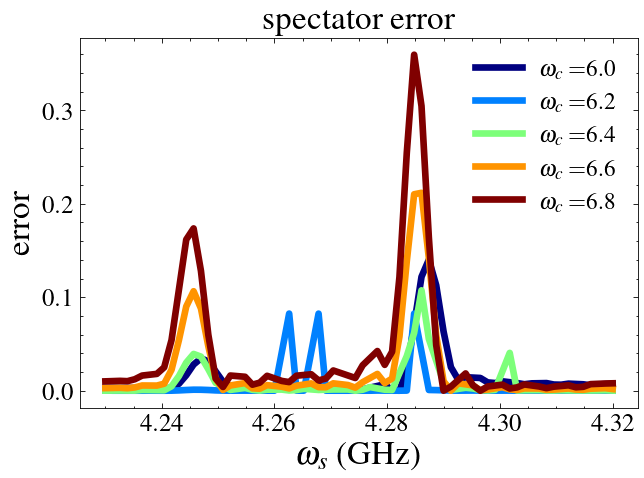

In [88]:
for i, _ in enumerate(error_arr):
    # 使用find_peaks函数找到峰值的索引和属性
    peaks, properties = find_peaks(error_arr[i], width=0)

    # 设置宽度的阈值w，比如10
    w = 3

    # 找到宽度小于w的峰值的索引
    narrow_peaks = peaks[properties["widths"] < w]

    # 把属于峰值的值变成其周围值的平均，得到一个新的信号
    error_arr_new = error_arr[i].copy() # 复制原始信号，避免修改原始数据
    for p in narrow_peaks: # 遍历每个峰值的索引
        # 找到峰值的左右邻居的索引，注意边界情况
        left = max(0, p - 1)
        right = min(len(error_arr[i])-1, p + 1)
        # 计算峰值的左右邻居的平均值
        mean = (error_arr[i][left] + error_arr[i][right]) / 2
        # 用平均值替换峰值的值
        error_arr_new[p] = mean
    error_arr[i] = error_arr_new

font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 20}
fig, ax = plt.subplots()
ax.set_xlabel(r'$\omega_s$ (GHz)', fontdict=font)
ax.set_ylabel(r'error', fontdict=font)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
# ax.axhline(0.01, linestyle=':', color='blue', linewidth=1)#, label=r'$10^{-3}$')  
# ax.set_yscale('log')
custom_color = ploter.cmap(np.linspace(0, 1, len(error_arr)))

ws_list = np.linspace(4.23, 4.32, 70)

for i, wc in enumerate(wc_list):
    label = fr'$\omega_c=$' + str(round(wc, 3))
    ax.plot(ws_list, error_arr[i] - np.min(error_arr[i]), linestyle='solid', label=label, color=custom_color[i])
ax.legend()
title = 'N=' + str(gate_num) + '观察比特频率对误差影响'
ax.set_title(r'spectator error', fontdict=font)
ax.legend(fontsize=14)
# cz.ploter.save_fig(fig, title)

In [8]:
for wc, leakage in enumerate(error_arr):
    peaks = []
    for i in range(1, len(leakage) - 1):
        if leakage[i] > leakage[i - 1] and leakage[i] > leakage[i + 1]:
            peaks.append((i, leakage[i]))

    peaks.sort(key=lambda x: x[1], reverse=True)

    leakFreqs1 = ws_list[peaks[0][0]]
    leakFreqs2 = ws_list[peaks[1][0]]

    g1 = np.abs(leakFreqs1 - leakFreqs2)
    g2 = 1 / (40 - 15 - 3)
    print(wc_list[wc], g1, g2, leakFreqs1, leakFreqs2)

6 0.03782608695652101 0.045454545454545456 4.286086956521739 4.248260869565218
6.2 0.039130434782609136 0.045454545454545456 4.284782608695653 4.245652173913044
6.4 0.03913043478260825 0.045454545454545456 4.286086956521739 4.246956521739131


从上面可以看出，存在明显的两个较高误差的位置，经过之前的分析，我们得到的结论是$|110\rangle\pm|020\rangle\leftrightarrow|011\rangle$通过观察coupler泄露的一种近邻相互作用。为了验证这一点，下面计算泄露随着观察coupler的变化。

In [39]:
ws_list = np.linspace(chip.q_dic['Q1']['w_idle'] - 0.06, chip.q_dic['Q1']['w_idle'] + 0.06, 100)
wc_list = np.linspace(6, 6.8, 5)
width = 40

gate_num = 7

arg_dic_list = [{
    **paras_best,
    **{
        'Q3': ws,
        'C2_3': wc
    }
} for ws, wc in product(ws_list, wc_list)]

evolution_result_list = qp.parallel_map(
    cz.run_evolution,
    arg_dic_list,
    task_kwargs={'parallel_args': ['arg_dic'],
                'width': width,
                'gate_num': gate_num,
                'init_state': (1, 1, 0)},
    progress_bar=True,
    num_cpus=cz.num_cpus)

expec_name = '011'
evo_result_list = [
    evolution_result.states[-1] for evolution_result in evolution_result_list
]

mea_ops = cz.Od(('Q1', 'Q2', 'Q3'), (0, 1, 1))

expect_list = qp.expect(mea_ops, evo_result_list)

10.0%. Run time:  38.23s. Est. time left: 00:00:05:44
20.0%. Run time:  66.66s. Est. time left: 00:00:04:26
30.0%. Run time:  83.40s. Est. time left: 00:00:03:14
40.0%. Run time: 111.70s. Est. time left: 00:00:02:47
50.0%. Run time: 129.59s. Est. time left: 00:00:02:09
60.0%. Run time: 157.73s. Est. time left: 00:00:01:45
70.0%. Run time: 179.53s. Est. time left: 00:00:01:16
80.0%. Run time: 204.37s. Est. time left: 00:00:00:51
90.0%. Run time: 230.28s. Est. time left: 00:00:00:25
100.0%. Run time: 248.28s. Est. time left: 00:00:00:00
Total run time: 248.43s


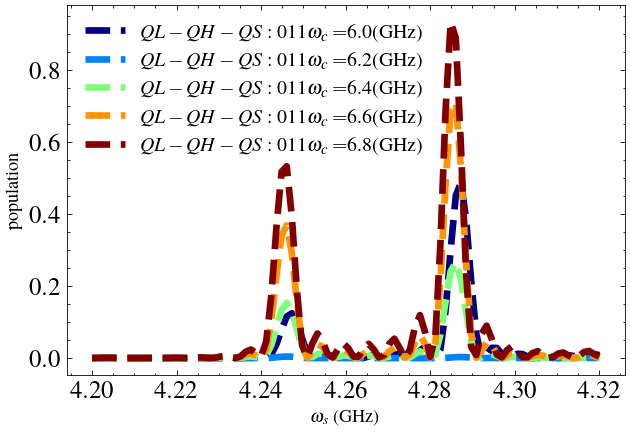

In [13]:
expect_arr = np.array(expect_list).reshape(len(ws_list), len(wc_list)).T

fig, ax = plt.subplots()
ax.set_xlabel(r'$\omega_s$ (GHz)')
ax.set_ylabel(r'population')
# ax.set_yscale('log')
custom_color = ploter.cmap(np.linspace(0, 1, len(expect_arr)))
for i, wc in enumerate(wc_list):
    label = fr'$QL-QH-QS: {expec_name} \omega_c=$' + str(round(wc, 3)) + '(GHz)'
    ax.plot(ws_list, expect_arr[i], linestyle='dashed', label=label, color=custom_color[i])
ax.legend()
title = fr'观察比特工作频率对泄漏的影响011'
# cz.ploter.save_fig(fig, title)

In [14]:
for wc, leakage in enumerate(expect_arr):
    peaks = []
    for i in range(1, len(leakage) - 1):
        if leakage[i] > leakage[i - 1] and leakage[i] > leakage[i + 1]:
            peaks.append((i, leakage[i]))

    peaks.sort(key=lambda x: x[1], reverse=True)

    leakFreqs1 = ws_list[peaks[0][0]]
    leakFreqs2 = ws_list[peaks[1][0]]

    g1 = np.abs(leakFreqs1 - leakFreqs2)
    g2 = 1 / (40 - 15 - 3)
    print(wc_list[wc], g1, g2, leakFreqs1, leakFreqs2)

6.0 0.040000000000000036 0.045454545454545456 4.287272727272727 4.247272727272727
6.2 0.04121212121212103 0.045454545454545456 4.246060606060606 4.287272727272727
6.4 0.03999999999999915 0.045454545454545456 4.286060606060605 4.246060606060606
6.6 0.03999999999999915 0.045454545454545456 4.286060606060605 4.246060606060606
6.8 0.03878787878787815 0.045454545454545456 4.284848484848484 4.246060606060606


为了验证这个双峰现象和buffer的相干无关，我们算一个长时间的泄露

In [15]:
ws_list = np.linspace(chip.q_dic['Q1']['w_idle'] - 0.06, chip.q_dic['Q1']['w_idle'] + 0.06, 100)
wc_list = np.linspace(6, 6.8, 5)
width = 200

gate_num = 1

arg_dic_list = [{
    **paras_best,
    **{
        'Q3': ws,
        'C2_3': wc
    }
} for ws, wc in product(ws_list, wc_list)]

evolution_result_list = qp.parallel_map(
    cz.run_evolution,
    arg_dic_list,
    task_kwargs={'parallel_args': ['arg_dic'],
                'width': width,
                'gate_num': gate_num,
                'init_state': (1, 1, 0)},
    progress_bar=True,
    num_cpus=cz.num_cpus)

expec_name = '011'
evo_result_list = [
    evolution_result.states[-1] for evolution_result in evolution_result_list
]

mea_ops = cz.Od(('Q1', 'Q2', 'Q3'), (0, 1, 1))

expect_list = qp.expect(mea_ops, evo_result_list)

expect_arr = np.array(expect_list).reshape(len(ws_list), len(wc_list)).T


10.0%. Run time:  50.40s. Est. time left: 00:00:07:33
20.0%. Run time:  74.81s. Est. time left: 00:00:04:59
30.0%. Run time:  98.21s. Est. time left: 00:00:03:49
40.0%. Run time: 122.24s. Est. time left: 00:00:03:03
50.0%. Run time: 144.01s. Est. time left: 00:00:02:24
60.0%. Run time: 169.05s. Est. time left: 00:00:01:52
70.0%. Run time: 192.42s. Est. time left: 00:00:01:22
80.0%. Run time: 215.88s. Est. time left: 00:00:00:53
90.0%. Run time: 239.02s. Est. time left: 00:00:00:26
100.0%. Run time: 260.08s. Est. time left: 00:00:00:00
Total run time: 260.22s


6.0 0.04606060606060591 0.045454545454545456 4.30060606060606 4.254545454545454
6.2 0.04606060606060591 0.045454545454545456 4.299393939393939 4.253333333333333
6.4 0.04606060606060591 0.045454545454545456 4.253333333333333 4.299393939393939
6.6 0.04606060606060591 0.045454545454545456 4.253333333333333 4.299393939393939
6.8 0.04606060606060591 0.045454545454545456 4.253333333333333 4.299393939393939


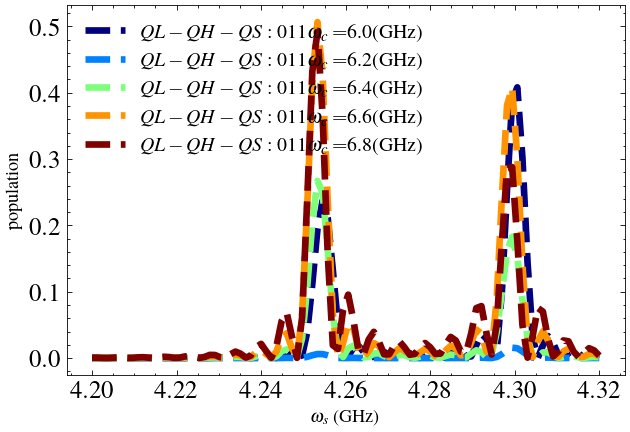

In [16]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$\omega_s$ (GHz)')
ax.set_ylabel(r'population')
# ax.set_yscale('log')
custom_color = ploter.cmap(np.linspace(0, 1, len(expect_arr)))
for i, wc in enumerate(wc_list):
    label = fr'$QL-QH-QS: {expec_name} \omega_c=$' + str(round(wc, 3)) + '(GHz)'
    ax.plot(ws_list, expect_arr[i], linestyle='dashed', label=label, color=custom_color[i])
ax.legend()

title = fr'观察比特工作频率对泄漏的影响011'
# cz.ploter.save_fig(fig, title)

for wc, leakage in enumerate(expect_arr):
    peaks = []
    for i in range(1, len(leakage) - 1):
        if leakage[i] > leakage[i - 1] and leakage[i] > leakage[i + 1]:
            peaks.append((i, leakage[i]))

    peaks.sort(key=lambda x: x[1], reverse=True)

    leakFreqs1 = ws_list[peaks[0][0]]
    leakFreqs2 = ws_list[peaks[1][0]]

    g1 = np.abs(leakFreqs1 - leakFreqs2)
    g2 = 1 / (40 - 15 - 3)
    print(wc_list[wc], g1, g2, leakFreqs1, leakFreqs2)


求出两个峰值对应的观察比特频率，根据两个频率的距离，我们可以得到两比特门对应的杂化态$|110\rangle\pm|020\rangle$的能级差$\Delta E=2\sqrt{2}g_{12}$

由另外，根据之前的分析，经过SW变换后的哈密顿量
\begin{align}
H&=H_0+\frac{1}{2}[S,H_v]\\
&=
\begin{pmatrix}
(\bm{H}_0)_1&\bm{g}_{12}&0\\\bm{g}_{12}^T&(\bm{H}_0)_2&0\\0&0&\bm{H}_1
\end{pmatrix}
\end{align}
其中
\begin{align}
\bm{g}_{12}=
\begin{pmatrix}
g_{2s}+\frac{g_{2c}g_{sc}}{2}\left(\frac{1}{\omega_1+\sqrt{2}g_{12}-\omega_c}+\frac{1}{\omega_s-\omega_c}-\frac{1}{\omega_c+\omega_1}-\frac{1}{\omega_c+\omega_s-\sqrt{2}g_{12}}\right)\\
g_{2s}+\frac{g_{2c}g_{sc}}{2}\left(\frac{1}{\omega_1-\sqrt{2}g_{12}-\omega_c}+\frac{1}{\omega_s-\omega_c}-\frac{1}{\omega_c+\omega_1}-\frac{1}{\omega_c+\omega_s+\sqrt{2}g_{12}}\right)
\end{pmatrix}
\end{align}
我们尝试找到理论上$\bm{g}_{12}=\bm{0}$的位置，看是否是泄露最小的位置。

In [33]:
ws_list = [4.2486398, 4.304337, 4.262]
wc_list = np.linspace(6, 6.5, 50)

init_state_list = list(qp.state_number_enumerate([2] * 2))
init_state_list = [(*init_state, 0) for init_state in init_state_list]

width = 40

gate_num = 7

arg_dic_list = [{
    **paras_best,
    **{
        'Q3': ws,
        'C2_3': wc_s
    }
} for ws, wc_s in product(ws_list, wc_list)]

results = []
for init_state in init_state_list:
    evolution_result_list = qp.parallel_map(
        cz.run_evolution,
        arg_dic_list,
        task_kwargs={'parallel_args': ['arg_dic'],
                    'width': width,
                    'gate_num': gate_num,
                    'init_state': init_state},
        progress_bar=True,
        num_cpus=cz.num_cpus)
    results.append(evolution_result_list)
    
fidelities = []
for i in range(len(evolution_result_list)):
    resulti = [results[0][i], results[1][i], results[2][i], results[3][i]]
    F = cz.analyze_fidelity(fidelity_result=resulti, type='ave')

    fidelities.append(F)

error_arr = np.array(fidelities).reshape(len(ws_list), len(wc_list))



10.0%. Run time:  14.01s. Est. time left: 00:00:02:06
20.0%. Run time:  20.53s. Est. time left: 00:00:01:22
30.0%. Run time:  27.53s. Est. time left: 00:00:01:04
40.0%. Run time:  32.97s. Est. time left: 00:00:00:49
50.0%. Run time:  42.15s. Est. time left: 00:00:00:42
60.0%. Run time:  46.73s. Est. time left: 00:00:00:31
70.0%. Run time:  55.57s. Est. time left: 00:00:00:23
80.0%. Run time:  63.29s. Est. time left: 00:00:00:15
90.0%. Run time:  68.81s. Est. time left: 00:00:00:07
100.0%. Run time:  75.61s. Est. time left: 00:00:00:00
Total run time:  75.77s
10.0%. Run time:  16.03s. Est. time left: 00:00:02:24
20.0%. Run time:  28.82s. Est. time left: 00:00:01:55
30.0%. Run time:  39.99s. Est. time left: 00:00:01:33
40.0%. Run time:  45.51s. Est. time left: 00:00:01:08
50.0%. Run time:  56.61s. Est. time left: 00:00:00:56
60.0%. Run time:  67.57s. Est. time left: 00:00:00:45
70.0%. Run time:  78.40s. Est. time left: 00:00:00:33
80.0%. Run time:  89.04s. Est. time left: 00:00:00:22
90.

In [34]:
ws_list = [4.2486398, 4.304337]
wc_list = np.linspace(6, 6.5, 50)

arg_dic_list = [{
    **paras_best,
    **{
        'Q3': ws,
        'C2_3': wc_s
    }
} for ws, wc_s in product(ws_list, wc_list)]

width = 100
evolution_result_list = qp.parallel_map(
    cz.run_evolution,
    arg_dic_list,
    task_kwargs={'parallel_args': ['arg_dic'],
                'width': width,
                'gate_num': gate_num,
                'init_state': (1, 1, 0)},
    progress_bar=True,
    num_cpus=cz.num_cpus)

# expec_name_list = ['110', '020', '011']
expec_name_list = ['011']
evo_result_list = [
    evolution_result.states for evolution_result in evolution_result_list
]
# mea_ops = [
    # cz.Od(('Q1', 'Q2', 'Q3'), (1, 1, 0)),
    # cz.Od(('Q1', 'Q2', 'Q3'), (0, 2, 0)),
    # cz.Od(('Q1', 'Q2', 'Q3'), (0, 1, 1)),
# ]
mea_ops = [
    cz.Od(('Q1', 'Q2', 'Q3'), (0, 1, 1)),
]

expect_list = [np.max(qp.expect(mea_ops, i)) for i in evo_result_list]
expect_arr = np.array(expect_list).reshape(len(ws_list), len(wc_list))

10.0%. Run time:  50.03s. Est. time left: 00:00:07:30
20.0%. Run time:  56.13s. Est. time left: 00:00:03:44
30.0%. Run time:  86.00s. Est. time left: 00:00:03:20
40.0%. Run time:  99.05s. Est. time left: 00:00:02:28
50.0%. Run time: 121.18s. Est. time left: 00:00:02:01
60.0%. Run time: 142.78s. Est. time left: 00:00:01:35
70.0%. Run time: 154.50s. Est. time left: 00:00:01:06
80.0%. Run time: 180.37s. Est. time left: 00:00:00:45
90.0%. Run time: 187.80s. Est. time left: 00:00:00:20
100.0%. Run time: 202.29s. Est. time left: 00:00:00:00
Total run time: 202.40s


画图

4.301513380357446
0.02127659574468085
14
50 50
29
50 50


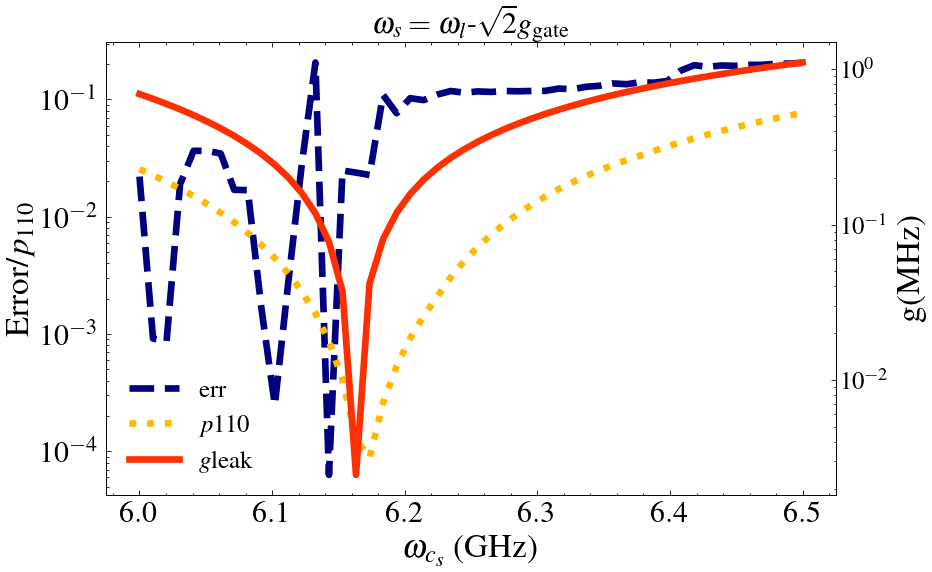

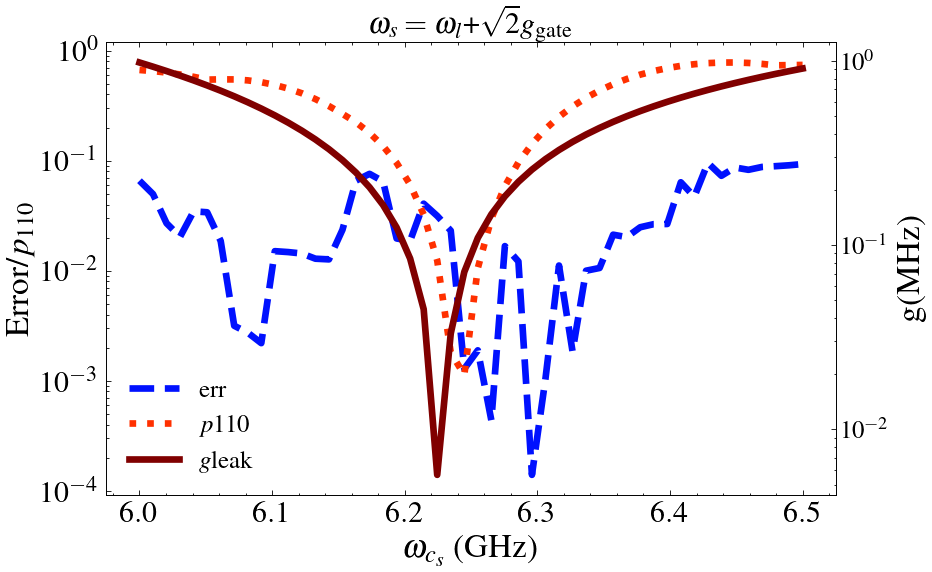

In [35]:
w2_work = paras_best['Q2']
w1 = w2_work + chip.q_dic['Q2']['eta'] + 0.018
gt = 1 / (2 * (40 - 15 - 1.5))
ws_list = [w1 - gt, w1 + gt]
wc_list = np.linspace(6, 6.5, 50)
gs = np.zeros((len(ws_list), len(wc_list)))

rho2s = cz.rho_map['Q2-Q3']
rho2c = cz.rho_map['Q2-C2_3']
rhosc = cz.rho_map['Q3-C2_3']

print(w1)
print(gt)

j = 0
for wc in wc_list:
    g2c = cz.rho2g(rho2c, [paras_best['Q2'], wc])
    g2s1 = cz.rho2g(rho2s, [paras_best['Q2'], ws_list[0]])
    gsc1 = cz.rho2g(rhosc, [ws_list[0], wc])
    g2s2 = cz.rho2g(rho2s, [paras_best['Q2'], ws_list[1]])
    gsc2 = cz.rho2g(rhosc, [ws_list[1], wc])
    
    g1 = np.abs(g2s2 + 0.5 * g2c * gsc2 * (1 / (w1 - gt - wc) + 1 / (ws_list[0] - wc) - 1 / (w1 + wc) - 1 / (wc + ws_list[0] + gt)))
    g2 = np.abs(g2s1 + 0.5 * g2c * gsc1 * (1 / (w1 + gt - wc) + 1 / (ws_list[1] - wc) - 1 / (w1 + wc) - 1 / (wc + ws_list[1] - gt)))
    gs[0, j] = g1
    gs[1, j] = g2
    j += 1

pm = ['-', '+']

for j, expec_name in enumerate(expec_name_list):
    for i, ws in enumerate(ws_list):
        fig, ax = plt.subplots()
        axtwin = ax.twinx()
        font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 20}
        axtwin.set_ylabel('g(MHz)',  fontdict=font)
        ax.set_xlabel(r'$\omega_{c_s}$ (GHz)',  fontdict=font)
        ax.set_ylabel(r'Error/$p_{110}$',  fontdict=font)
        ax.tick_params(axis='x', labelsize=18)
        ax.tick_params(axis='y', labelsize=18)
        ax.set_yscale('log')
        axtwin.set_yscale('log')
        custom_color = ploter.cmap(np.linspace(0, 1, 8))
        data = np.abs(error_arr[i] - error_arr[-1]) 
        min_index = np.argmin(data)
        print(min_index)
        for ii in range(len(data)):
            if ii < min_index - 4:
                data[ii] = (data[ii] + data[ii + 1] + data[ii + 2]) / 2
            elif ii > min_index + 4:
                data[ii] = (data[ii] + data[ii - 1] + data[ii - 2]) / 2

        print(len(wc_list), len(data))

        ax.plot(wc_list, data, linestyle='--', label='err', color=custom_color[i])
        axtwin.plot(wc_list, gs[i] * 1e3, linestyle='-', label=r'$g$leak ', color=custom_color[i + 6])
        ax.plot(wc_list, expect_arr[i], linestyle=':', label=r'$p110$', color=custom_color[i + 5])
        handles1, labels1 = ax.get_legend_handles_labels()
        handles2, labels2 = axtwin.get_legend_handles_labels()
        ax.legend(handles1 + handles2, labels1 + labels2, fontsize=15)
        title = r'$\omega_s=\omega_l$' + pm[i] + r'$\sqrt{2}g_\text{gate}$'
        ax.set_title(title, fontsize=18)
        plt.tight_layout()
        title = 'g cut off ' + str(i) + '.pdf'
        output_path = Path.cwd()/ 'figures' / title
        plt.savefig(output_path, dpi=300)
#         plt.close()

In [57]:
for i, ws in enumerate(ws_list):
    print('error', i, wc_list[np.argmin(error_arr[i])])
    print('gs', i, wc_list[np.argmin(gs[i])])
for j, expec_name in enumerate(expec_name_list):
    for i, ws in enumerate(ws_list):
        print('leakage', i, wc_list[np.argmin(expect_arr[i])])

error 0 6.404040404040404
gs 0 6.387878787878788
error 1 6.37979797979798
gs 1 6.3232323232323235
leakage 0 6.387878787878788
leakage 1 6.331313131313131


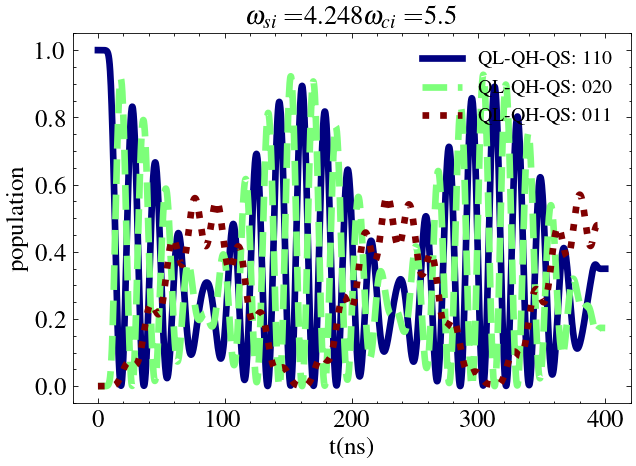

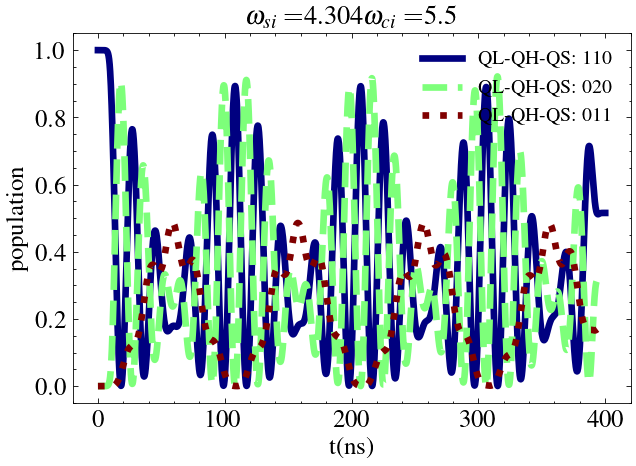

In [6]:
for wsi in [4.2480664, 4.3039193]:
    for wci in [5.5]:
        arg_dic = {**paras_best, 'Q3': wsi, 'C2_3': wci}

        gate_num = 1
        width = 400

        expec_name_list = ['110', '020', '011']

        mea_ops = [
            cz.Od(('Q1', 'Q2', 'Q3'), (1, 1, 0)),
            cz.Od(('Q1', 'Q2', 'Q3'), (0, 2, 0)),
            cz.Od(('Q1', 'Q2', 'Q3'), (0, 1, 1)),
        ]


        evolution_result = cz.run_evolution(arg_dic, width=width, gate_num=gate_num, init_state=(1, 1, 0))

        expect_list = qp.expect(mea_ops, evolution_result.states)

        fig, ax = plt.subplots()
        ax.set_xlabel('t(ns)')
        ax.set_ylabel(r'population')
        # ax.set_yscale('log')
        custom_color = ploter.cmap(np.linspace(0, 1, len(expec_name_list)))
        for i, expec_name in enumerate(expec_name_list):
            label = fr'QL-QH-QS: {expec_name}'
            ax.plot(evolution_result.times, expect_list[i], label=label, color=custom_color[i])

        ax.legend()
        title = r'$\omega_{si}=$' + str(round(wsi, 3)) + r'$\omega_{ci}=$' + str(round(wci, 3))
        ax.set_title(title)
        # ploter.save_fig(fig, title)

为了看到共振峰中间的情况，我们只看$|011\rangle$

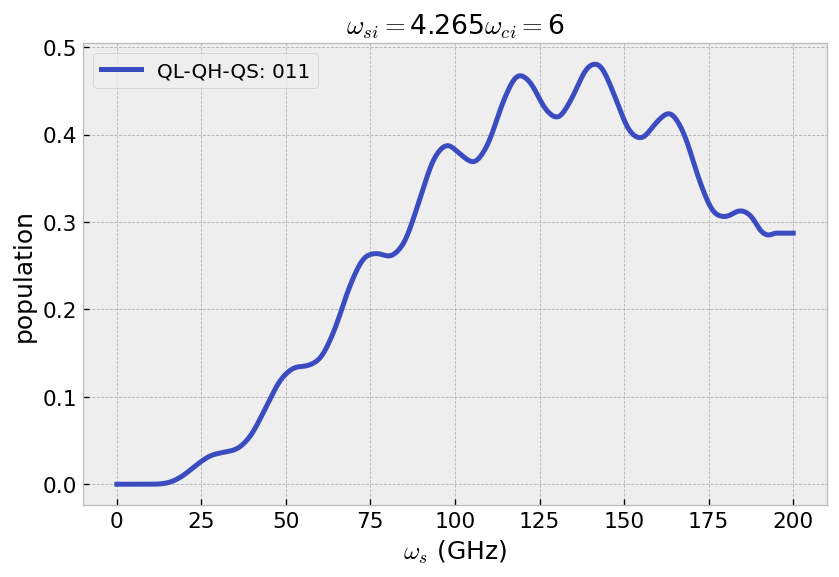

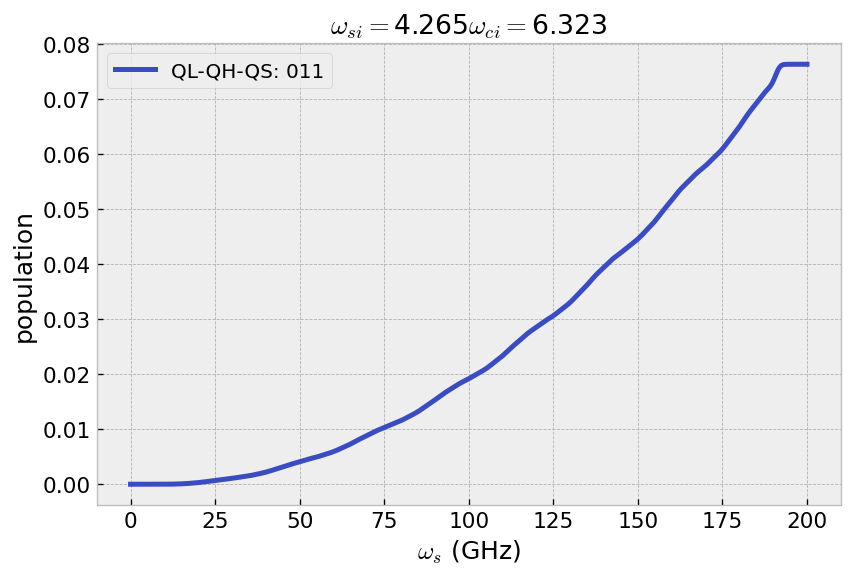

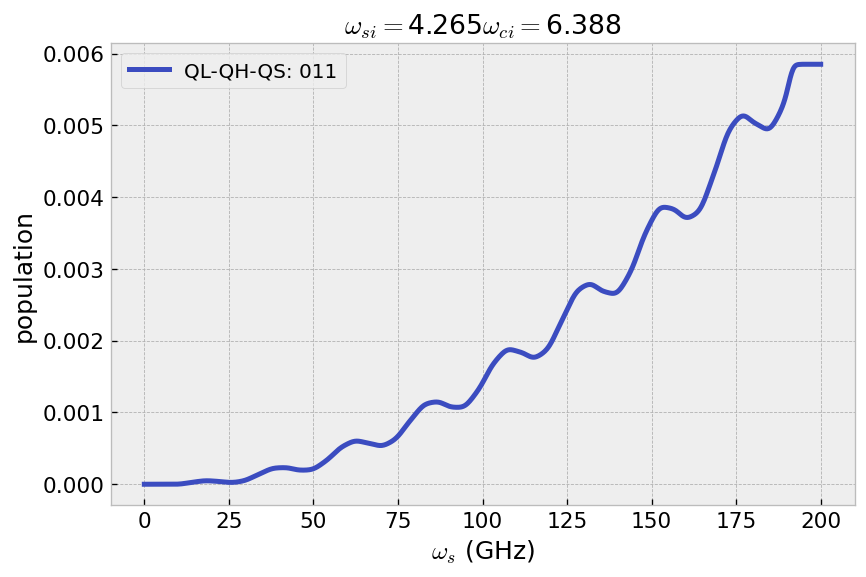

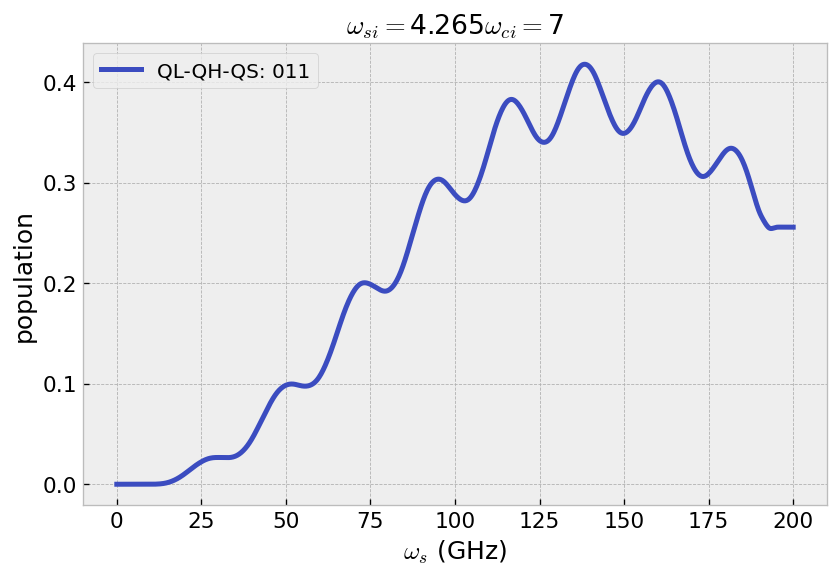

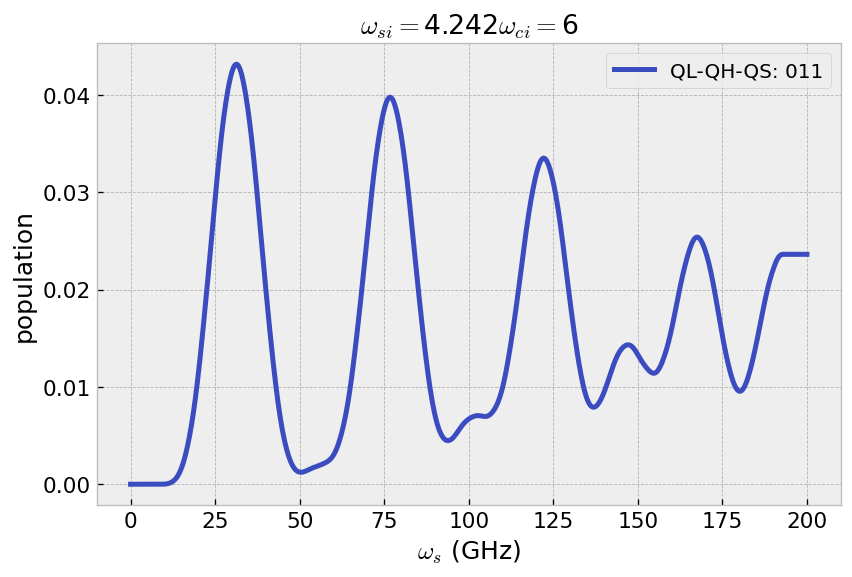

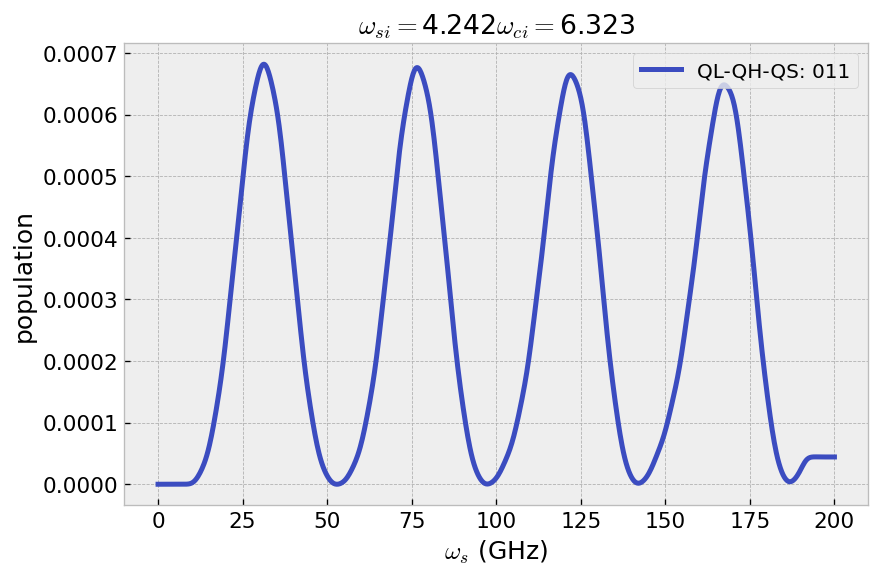

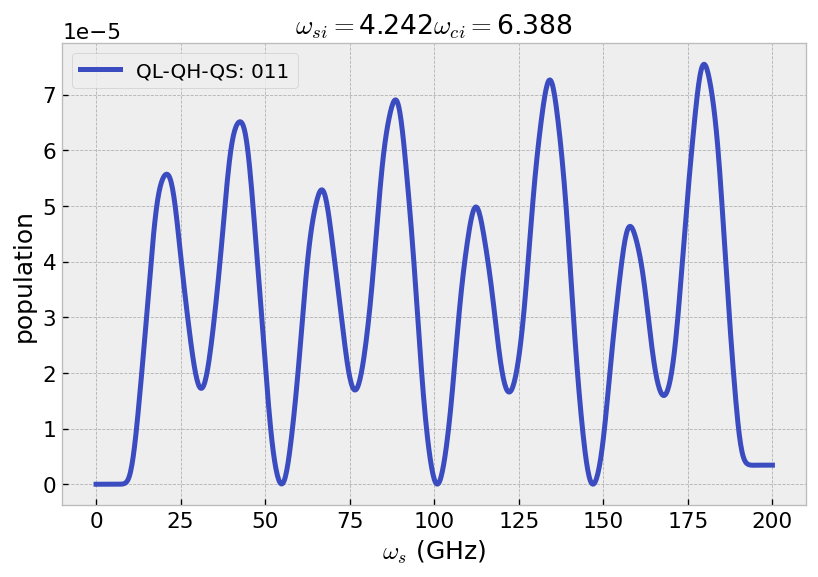

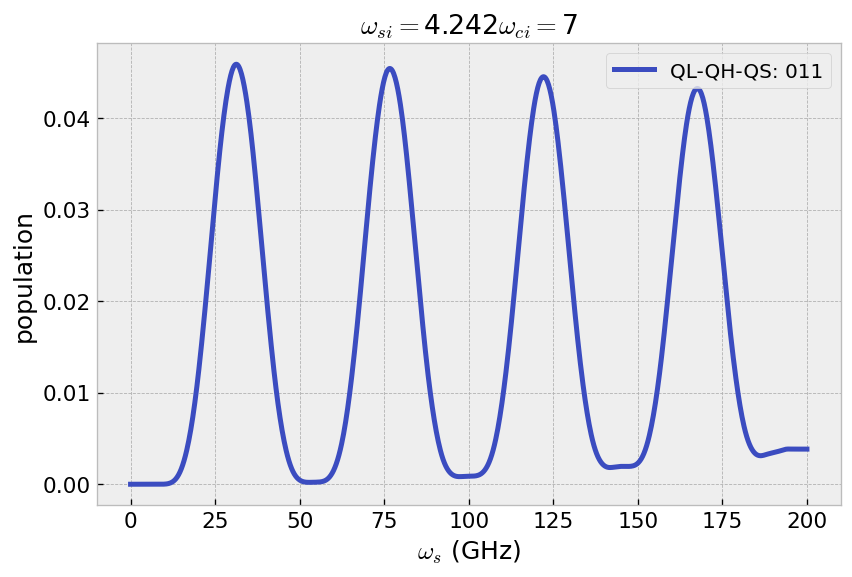

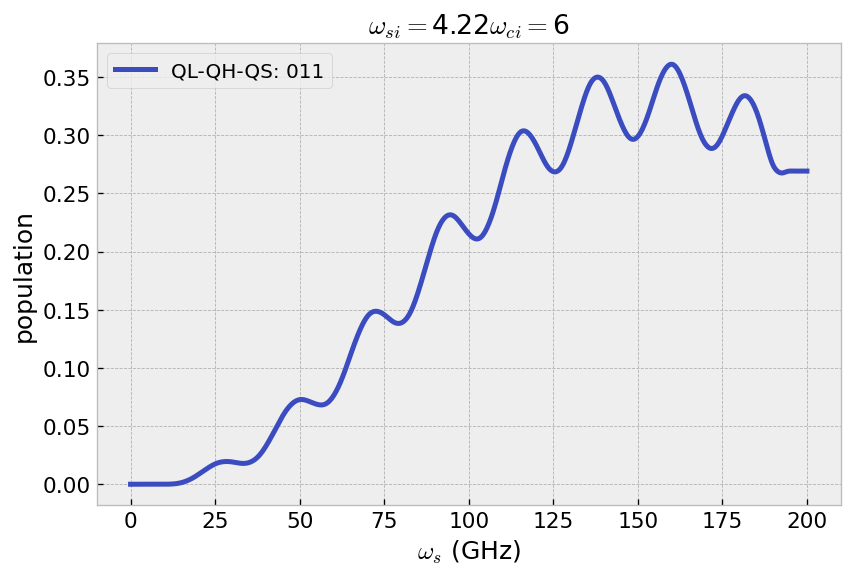

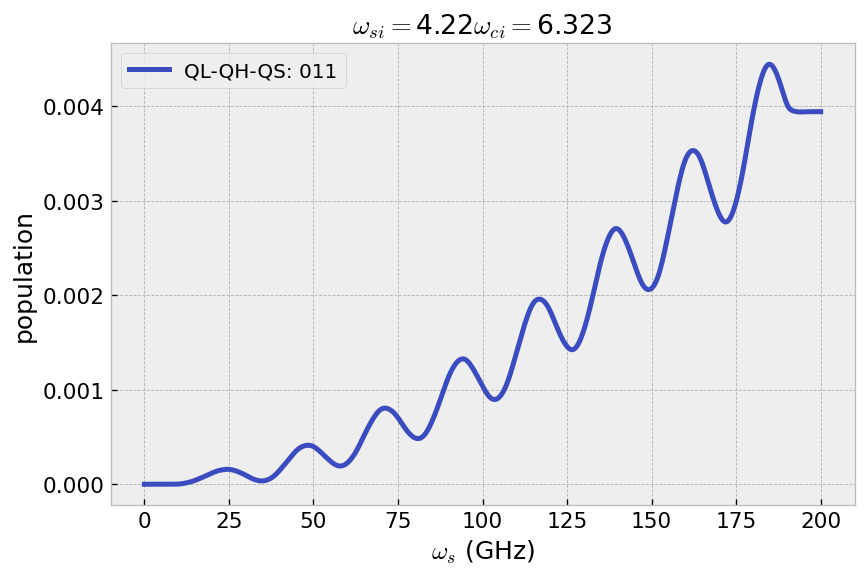

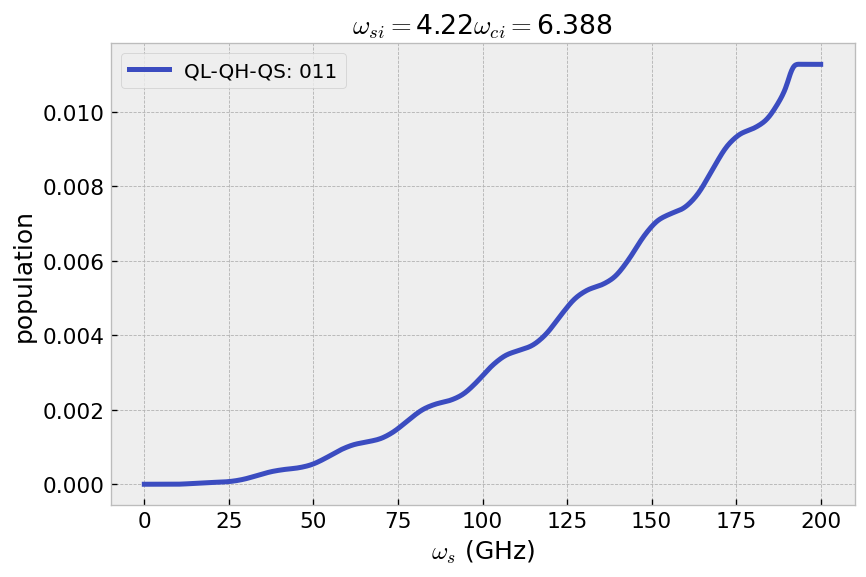

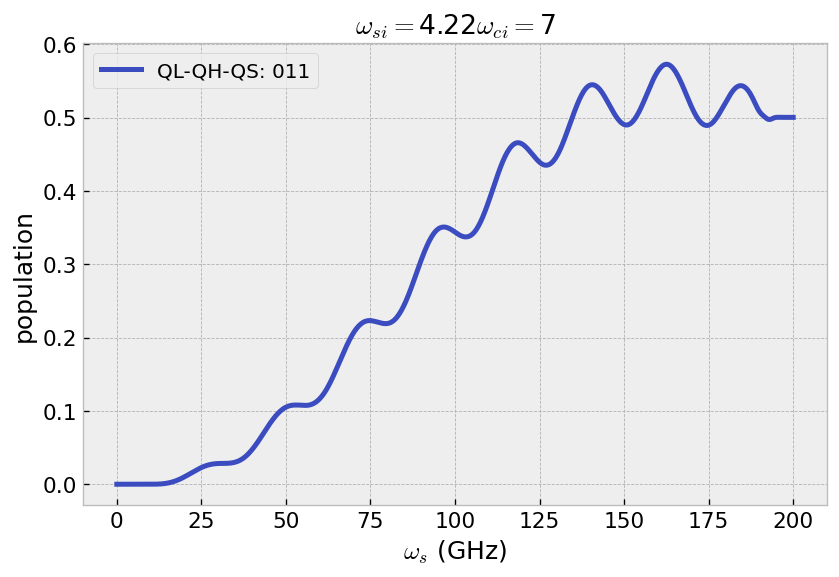

In [6]:
for wsi in [4.265, (4.265 + 4.22) / 2, 4.22]:
    for wci in [6, 6.323, 6.388, 7]:
        arg_dic = {**paras_best, 'Q3': wsi, 'C2_3': wci}

        gate_num = 1
        width = 200

        expec_name_list = ['011']

        mea_ops = [
            cz.Od(('Q1', 'Q2', 'Q3'), (0, 1, 1)),
        ]


        evolution_result = cz.run_evolution(arg_dic, width=width, gate_num=gate_num, init_state=(1, 1, 0))

        expect_list = qp.expect(mea_ops, evolution_result.states)

        fig, ax = plt.subplots()
        ax.set_xlabel(r'$\omega_s$ (GHz)')
        ax.set_ylabel(r'population')
        # ax.set_yscale('log')
        custom_color = cz.ploter.cmap(np.linspace(0, 1, len(expec_name_list)))
        for i, expec_name in enumerate(expec_name_list):
            label = fr'QL-QH-QS: {expec_name}'
            ax.plot(evolution_result.times, expect_list[i], label=label, color=custom_color[i])

        ax.legend()
        title = r'$\omega_{si}=$' + str(round(wsi, 3)) + r'$\omega_{ci}=$' + str(round(wci, 3))
        ax.set_title(title)
        # cz.ploter.save_fig(fig, title)

从上述仿真得到的结论

确实在两个相差为$2\sqrt{2}g_{12}$的频率处出现了比较明显的泄露问题。

如果把coupler放在等效关断耦合频率$f_g$确实能有效抑制泄露。

但是，这不能解释门数目$N_g=1$时，没有明显双峰的问题。

串扰随着$\Delta=|\omega_s-\omega_g|$增加不断衰减。

由拉比振荡，随着detune增加，低频，大振幅的震荡会逐步变为高频，小振幅的振荡。

在两个泄漏峰中间，$\Delta=\left\lvert\frac{f_{s1}-f_{s2}}{2}\right\rvert$，泄漏的振幅没有完全衰减到0。

当门时间$t_g$比较小的时候，高频泄漏的布局数高于低频，大振幅的布局数，导致泄漏图只有一个宽峰。

In [36]:
ws_list = np.linspace(4.23, 4.32, 100)
wc_list = [5.5]
arg_dic_list = [{
    **paras_best,
    **{
        'Q3': ws,
        'C2_3': wc
    }
} for ws, wc in product(ws_list, wc_list)]

gate_num = 1
width = 1000
init_state = (1, 1, 0)

evolution_result_list = qp.parallel_map(
    cz.run_evolution,
    arg_dic_list,
    task_kwargs={'parallel_args': ['arg_dic'],
                'width': width,
                'gate_num': gate_num,
                'init_state': init_state},
    progress_bar=True,
    # num_cpus=cz.num_cpus)
    num_cpus=20)

mea_ops = cz.Od(('Q1', 'Q2', 'Q3'), (0, 1, 1))

expect_arr = [
    qp.expect(mea_ops, evolution_result.states) for evolution_result in evolution_result_list
]


10.0%. Run time:  50.99s. Est. time left: 00:00:07:38
20.0%. Run time:  66.56s. Est. time left: 00:00:04:26
30.0%. Run time:  96.86s. Est. time left: 00:00:03:46
40.0%. Run time: 118.20s. Est. time left: 00:00:02:57
50.0%. Run time: 133.36s. Est. time left: 00:00:02:13
60.0%. Run time: 155.18s. Est. time left: 00:00:01:43
70.0%. Run time: 177.72s. Est. time left: 00:00:01:16
80.0%. Run time: 202.27s. Est. time left: 00:00:00:50
90.0%. Run time: 215.26s. Est. time left: 00:00:00:23
100.0%. Run time: 232.68s. Est. time left: 00:00:00:00
Total run time: 232.79s


In [37]:
P_name = '011'

X, Y = np.meshgrid(ws_list, evolution_result_list[0].times)
fig, ax = plt.subplots(figsize=(6, 4))
norm = mpl.colors.LogNorm()
c = ax.pcolormesh(X * 1000,
                  Y,
                  np.array(expect_arr).T,
                  cmap='coolwarm')
cb = plt.colorbar(c, ax=ax)
font = {'size': 18}
cb.set_label(rf'$P_{{{P_name}}}$', fontdict=font)
ax.set_xlabel(r'$\omega_{s}$ (MHz)', fontdict=font)
ax.set_ylabel(r'width (ns)', fontdict=font)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='both', which='major', width=2)  # 主刻度


cb.ax.tick_params(labelsize=15)
spines = ax.spines

# 设置四个边框线的宽度
for spine in spines.values():
    spine.set_linewidth(1.)  # 设置线宽为2

ax.set_title(r'long swap theory', fontdict=font)
plt.tight_layout()
title = 'long swap theory' + '.pdf'
output_path = Path.cwd()/ 'figures' / title
plt.savefig(output_path, dpi=300)
plt.close()

C:\Users\KUSANA~1\AppData\Local\Temp/ipykernel_14224/1869349346.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(X * 1000,


改变$\omega_s$以及$\omega_{c_s}$的频率，看泄漏的赋值关断点

In [38]:
paras_best = {'Q2': 4.519, 'C1_2': 4.8}

ws_list = np.linspace(4.23, 4.32, 50)
wc_list = np.linspace(5.0, 6.5, 50)
arg_dic_list = [{
    **paras_best,
    **{
        'Q3': ws,
        'C2_3': wc
    }
} for ws, wc in product(ws_list, wc_list)]

gate_num = 1
width = 40
init_state = (1, 1, 0)

evolution_result_list_wcws = qp.parallel_map(
    cz.run_evolution,
    arg_dic_list,
    task_kwargs={'parallel_args': ['arg_dic'],
                'width': width,
                'gate_num': gate_num,
                'init_state': init_state},
    progress_bar=True,
    # num_cpus=cz.num_cpus)
    num_cpus=20)

10.0%. Run time:  29.80s. Est. time left: 00:00:04:28
20.0%. Run time:  50.98s. Est. time left: 00:00:03:23
30.0%. Run time:  72.39s. Est. time left: 00:00:02:48
40.0%. Run time:  93.44s. Est. time left: 00:00:02:20
50.0%. Run time: 114.30s. Est. time left: 00:00:01:54
60.0%. Run time: 134.94s. Est. time left: 00:00:01:29
70.0%. Run time: 155.86s. Est. time left: 00:00:01:06
80.0%. Run time: 175.92s. Est. time left: 00:00:00:43
90.0%. Run time: 196.06s. Est. time left: 00:00:00:21
100.0%. Run time: 216.46s. Est. time left: 00:00:00:00
Total run time: 216.55s


fig path: f:\onedrive\vs experiment\freqalloc_tsq\figures\2024-07\0730-22.20.03_全比特最大泄露关断图.png


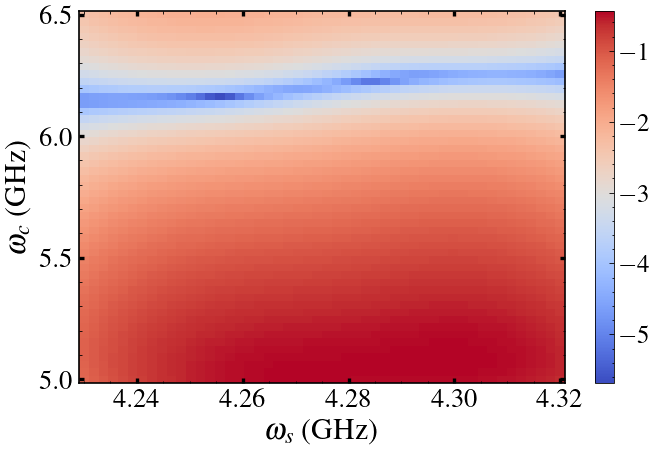

In [22]:
mea_ops = cz.Od(('Q1', 'Q2', 'Q3'), (0, 1, 1))

# expect_arr_wcws = [
    # np.max(qp.expect(mea_ops, evolution_result.states)) for evolution_result in evolution_result_list_wcws
# ]

expect_arr_wcws = [
    qp.expect(mea_ops, evolution_result.states[-1]) for evolution_result in evolution_result_list_wcws
]

X, Y = np.meshgrid(ws_list, wc_list)
fig, ax = plt.subplots(figsize=(6, 4))
expect_arr_wcws = np.array(expect_arr_wcws).reshape(len(ws_list), len(wc_list)).T
c = ax.pcolormesh(X,
                  Y,
                  np.log10(np.array(expect_arr_wcws)),
                  cmap='coolwarm')

cb = plt.colorbar(c, ax=ax)
font = {'size': 18}
# cb.set_label(rf'$P_{{{P_name}}}$', fontdict=font)
ax.set_xlabel(r'$\omega_{s}$ (GHz)', fontdict=font)
ax.set_ylabel(r'$\omega_{c}$ (GHz)', fontdict=font)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='both', which='major', width=2)  # 主刻度

cb.ax.tick_params(labelsize=15)
spines = ax.spines

# 设置四个边框线的宽度
for spine in spines.values():
    spine.set_linewidth(1.)  # 设置线宽为2
    
plt.tight_layout()
ploter.save_fig(fig, rf'全比特最大泄露关断图', flag_save=True)

双拉比模型

In [18]:
def g_calculation(cz, paras_best, ws, wc, w1, w2):
    rho2s = cz.rho_map['Q2-Q3']
    rho2c = cz.rho_map['Q2-C2_3']
    rhosc = cz.rho_map['Q3-C2_3']

    wBare = (w1 + w2) / 2
    gt = np.abs(w1 - w2) / 2
    
    g2c = cz.rho2g(rho2c, [paras_best['Q2'], wc])
    g2s = cz.rho2g(rho2s, [paras_best['Q2'], ws])
    gsc = cz.rho2g(rhosc, [ws, wc])
    g1 = np.abs(g2s + 0.5 * g2c * gsc * (1 / (wBare - gt - wc) + 1 / (ws - wc) - 1 / (wBare + wc) - 1 / (wc + ws + gt)))
    g2 = np.abs(g2s + 0.5 * g2c * gsc * (1 / (wBare + gt - wc) + 1 / (ws - wc) - 1 / (wBare + wc) - 1 / (wc + ws - gt)))
    
    return g1, g2

def Rabi(g, detune, t):
    omega = 2 * g * np.pi * 2
    detune *= np.pi * 2
    return np.exp(-1j * detune * t / 2) * 1 / np.sqrt(2) * omega / np.sqrt(omega**2 + detune**2) * np.sin(0.5 * np.sqrt(omega**2 + detune**2) * t)


def double_rabi(cz, paras_best, w1, w2, wc, ws, t):
    g1, g2 = g_calculation(cz, paras_best, ws, wc, w1, w2)
    return abs(Rabi(g1, w1 - ws, t) + Rabi(g2, w2 - ws, t)) ** 2


In [19]:
def get_theory_osc_freq(cz, paras_best, f1, f2, wc, ws_list, t):
    X, Y = np.meshgrid(ws_list, t)
    theory = double_rabi(cz, paras_best, f1, f2, wc, X, Y)
    osc_freq_list = []
    for i in range(len(ws_list)):
        P_list = theory.T[i][50:]
        osc_freq = fit_cos(t[50:], P_list)[0][0]
        osc_freq_list.append(osc_freq)
    return np.array(osc_freq_list)

def get_sim_osc_freq(exp_arr, t):
    osc_freq_list = []
    for i in range(len(exp_arr)):
        P_list = exp_arr[i][50:]
        osc_freq = fit_cos(t[50:], P_list)[0][0]
        osc_freq_list.append(osc_freq)
    return np.array(osc_freq_list)
        
def error(paras, *args):
    w1, w2, wc = paras
    ws_list, exp_arr, t = args
    return get_sim_osc_freq(exp_arr, t) - get_theory_osc_freq(cz, paras_best, w1, w2, wc, ws_list, t)


In [49]:
w1 = 4.249
w2 = 4.305
wc = 5.5

ws_list = np.linspace(4.23, 4.32, 100)
t = evolution_result_list[0].times

popt0 = [w1, w2, wc]
lb = [4, 4, 5]
ub = [5, 5, 7]
res = least_squares(error, x0=popt0, bounds=(lb, ub), args=(ws_list, expect_arr, t))
popt = res.x
popt

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of fu

array([4.2565465, 4.3017859, 5.4656498])

Optimal parameters not found: The maximum number of function evaluations is exceeded.


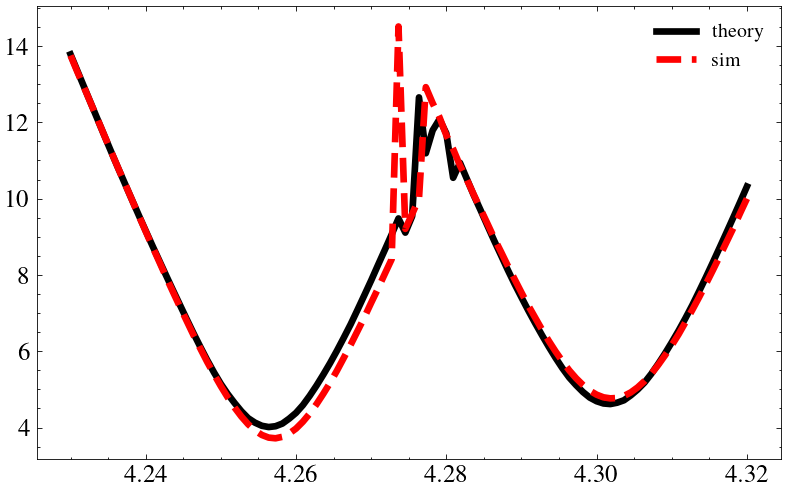

In [51]:
theory_osc_freq = get_theory_osc_freq(cz, paras_best, *popt, ws_list, t) * 1000 / 2
sim_osc_freq = get_sim_osc_freq(expect_arr, t) * 1000 / 2

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ws_list, theory_osc_freq, label='theory')
ax.plot(ws_list, sim_osc_freq, label='sim')
ax.legend()
# ploter.save_fig(fig, 'oscfreq.pdf')

In [25]:
popt = [4.2486398, 4.304337, 5.4987641]

根据理论计算等效耦合

In [49]:
w1, w2, wc = popt
wBare = (w1 + w2) / 2
g_gate = (w2 - w1) / 2
g_minis, g_plus = g_calculation(w1, wc, w1, w2)
print(g_minis, g_plus)
g_minis, g_plus = g_calculation(w2, wc, w1, w2)
print(g_minis, g_plus)
ws_list = np.linspace(4.23, 4.32, 100)
t = np.linspace(0, 15, 100)
X, Y = np.meshgrid(ws_list, t)
theory = double_rabi(w1, w2, wc, X, Y)

0.0036131350438612132 0.003955804268557059
0.003971036140511785 0.004315883679418124


fig path: f:\onedrive\vs experiment\freqalloc_tsq\figures\2024-07\0730-22.44.48_Rabi模型布局数图.png


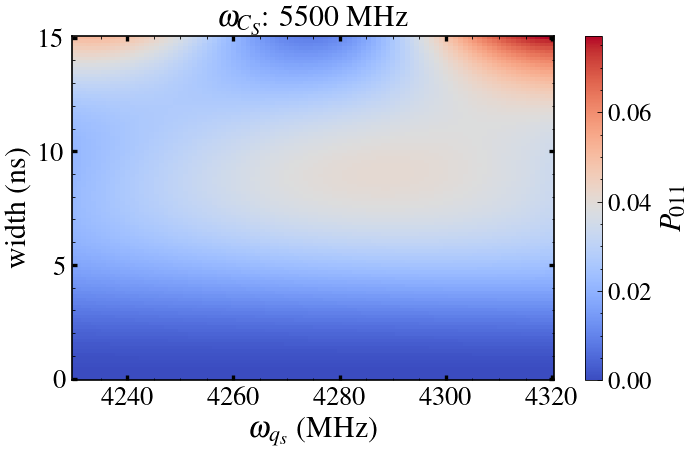

In [50]:
P_name = '011'

X, Y = np.meshgrid(ws_list, t)
fig, ax = plt.subplots(figsize=(6, 4))
norm = mpl.colors.LogNorm()
c = ax.pcolormesh(X * 1000,
                  Y,
                  theory,
                  cmap='coolwarm')
cb = plt.colorbar(c, ax=ax)
font = {'size': 18}
cb.set_label(rf'$P_{{{P_name}}}$', fontdict=font)
ax.set_xlabel(r'$\omega_{q_s}$ (MHz)', fontdict=font)
ax.set_ylabel(r'width (ns)', fontdict=font)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='both', which='major', width=2)  # 主刻度


cb.ax.tick_params(labelsize=15)
spines = ax.spines

# 设置四个边框线的宽度
for spine in spines.values():
    spine.set_linewidth(1.)  # 设置线宽为2

# CS = ax.contour(X, Y, X, [4216.8],norm=norm, colors='red')
# ax.clabel(CS, inline=True, fontsize=12)
ax.set_title(r'$\omega_{C_S}$: 5500 MHz', fontdict=font)
plt.tight_layout()
ploter.save_fig(fig, rf'Rabi模型布局数图', flag_save=True)
# plt.savefig(os.path.join(folder_path, rf'swap图.png'))

改变$\omega_s$以及$\omega_{c_s}$的频率，看泄漏的关断点

In [32]:
def xyzG(ws_list, wc_list, t, w1, w2):
    theorys = np.zeros((len(ws_list), len(wc_list), len(t)))
    i = 0
    for ws in ws_list:
        j = 0
        for wc in wc_list:
            theorys[i, j] = double_rabi(w1, w2, wc, ws, t)
            j += 1
        i += 1
    return theorys

In [51]:
t = np.linspace(0, 15, 100)
ws_list = np.linspace(4.23, 4.32, 100)
wc_list = np.linspace(5.0, 6.5, 100)
w1, w2 = popt[0], popt[1]
rabiTheorys = xyzG(ws_list, wc_list, t, w1, w2)
# rabiTheorys = np.max(rabiTheorys, axis=2)
rabiTheorys = rabiTheorys[:, :, -1]
X, Y, Z = np.meshgrid(ws_list, wc_list, t)

100 100
fig path: f:\onedrive\vs experiment\freqalloc_tsq\figures\2024-07\0730-22.45.12_Rabi模型最大泄露关断图.png


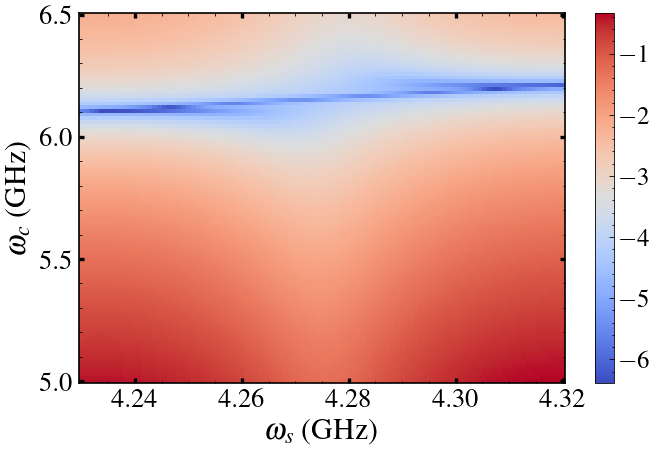

In [52]:
X, Y = np.meshgrid(ws_list, wc_list)
print(len(wc_list), len(ws_list))
fig, ax = plt.subplots(figsize=(6, 4))
c = ax.pcolormesh(X,
                  Y,
                  np.log10(np.array(rabiTheorys)).T,
                  cmap='coolwarm')

cb = plt.colorbar(c, ax=ax)
font = {'size': 18}
# cb.set_label(rf'$P_{{{P_name}}}$', fontdict=font)
ax.set_xlabel(r'$\omega_{s}$ (GHz)', fontdict=font)
ax.set_ylabel(r'$\omega_{c}$ (GHz)', fontdict=font)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='both', which='major', width=2)  # 主刻度

cb.ax.tick_params(labelsize=15)
spines = ax.spines

# 设置四个边框线的宽度
for spine in spines.values():
    spine.set_linewidth(1.)  # 设置线宽为2
    
# ax.set_title(r'$$', fontdict=font)
plt.tight_layout()
ploter.save_fig(fig, rf'Rabi模型最大泄露关断图', flag_save=True)

三能级哈密顿量模拟

In [53]:
w1, w2, wc = popt
ws_list = np.linspace(4.23, 4.32, 100)
# 时间范围
t_list = np.linspace(0, 15, 100)


threeLevels = np.zeros((len(ws_list), len(t_list)))

i = 0
for ws in ws_list:
    
    g1, g2 = g_calculation(ws, wc, w1, w2)

    # 哈密顿量定义
    H = np.array([[w1, 0, g1], 
                [0, w2, g2], 
                [g1, g2, ws]]) * np.pi * 2

    H = Qobj(H)

    # 初始状态 (可以根据需要调整)
    initial_state = (basis(3, 0) + basis(3, 1)) / np.sqrt(2)  # 初态为第一个能级
    
    # 进行时间演化
    result = mesolve(H, initial_state, t_list, e_ops=[basis(3, 2) * basis(3, 2).dag()])

    # 获取期望值列表中的最大值并赋给 threeLevels[i, j]
    threeLevels[i] = result.expect[0]
    i += 1

fig path: f:\onedrive\vs experiment\freqalloc_tsq\figures\2024-07\0730-22.47.35_三能级泄漏布局数图.png


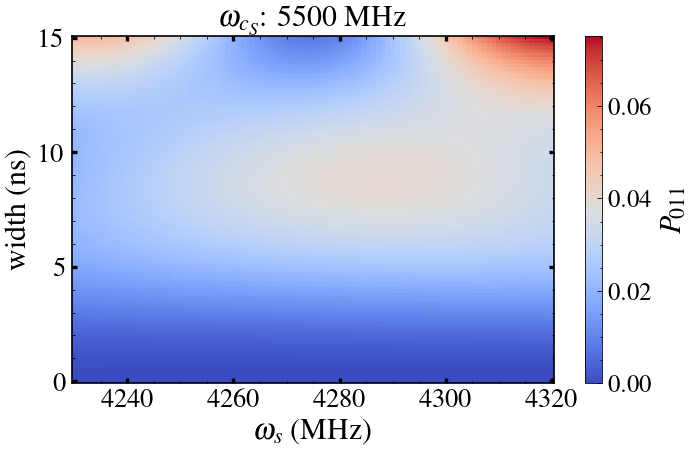

In [54]:
P_name = '011'

X, Y = np.meshgrid(ws_list, t_list)
fig, ax = plt.subplots(figsize=(6, 4))
norm = mpl.colors.LogNorm()
c = ax.pcolormesh(X * 1000,
                  Y,
                  threeLevels.T,
                  cmap='coolwarm')
cb = plt.colorbar(c, ax=ax)
font = {'size': 18}
cb.set_label(rf'$P_{{{P_name}}}$', fontdict=font)
ax.set_xlabel(r'$\omega_{s}$ (MHz)', fontdict=font)
ax.set_ylabel(r'width (ns)', fontdict=font)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='both', which='major', width=2)  # 主刻度


cb.ax.tick_params(labelsize=15)
spines = ax.spines

# 设置四个边框线的宽度
for spine in spines.values():
    spine.set_linewidth(1.)  # 设置线宽为2

ax.set_title(r'$\omega_{c_S}$: 5500 MHz', fontdict=font)
plt.tight_layout()
ploter.save_fig(fig, rf'三能级泄漏布局数图', flag_save=True)

In [55]:
w1, w2, _ = popt
ws_list = np.linspace(4.23, 4.32, 100) 
wc_list = np.linspace(5.0, 6.5, 100) 
# 时间范围
t_list = np.linspace(0, 15, 100)

threeLevels = np.zeros((len(ws_list), len(wc_list)))

i = 0
for ws in ws_list:
    j = 0
    for wc in wc_list:
        
        g1, g2 = g_calculation(ws, wc, w1, w2)
        
        # 哈密顿量定义
        H = np.array([[w1, 0, g1], 
                    [0, w2, g2], 
                    [g1, g2, ws]]) * np.pi * 2

        H = Qobj(H)

        # 初始状态 (可以根据需要调整)
        initial_state = (basis(3, 0) + basis(3, 1)) / np.sqrt(2)  # 初态为第一个能级

        # 进行时间演化
        result = mesolve(H, initial_state, t_list, e_ops=[basis(3, 2) * basis(3, 2).dag()])

        # 获取期望值列表中的最大值并赋给 threeLevels[i, j]
        expect_values = result.expect[0]
        # threeLevels[i, j] = np.max(expect_values)
        threeLevels[i, j] = expect_values[-1]
        
        j += 1
    i += 1


100 100
fig path: f:\onedrive\vs experiment\freqalloc_tsq\figures\2024-07\0730-22.49.18_三能级泄露最大关断图.png


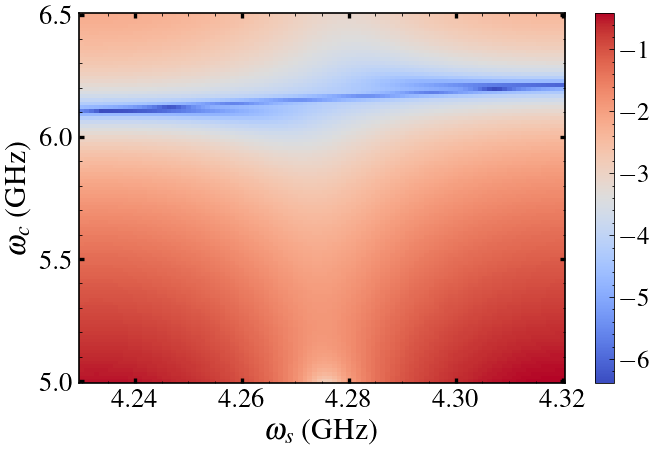

In [56]:
X, Y = np.meshgrid(ws_list, wc_list)
print(len(wc_list), len(ws_list))
fig, ax = plt.subplots(figsize=(6, 4))
c = ax.pcolormesh(X,
                  Y,
                  np.log10(np.array(threeLevels)).T,
                  cmap='coolwarm')

cb = plt.colorbar(c, ax=ax)
font = {'size': 18}
# cb.set_label(rf'$P_{{{P_name}}}$', fontdict=font)
ax.set_xlabel(r'$\omega_{s}$ (GHz)', fontdict=font)
ax.set_ylabel(r'$\omega_{c}$ (GHz)', fontdict=font)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='both', which='major', width=2)  # 主刻度

cb.ax.tick_params(labelsize=15)
spines = ax.spines

# 设置四个边框线的宽度
for spine in spines.values():
    spine.set_linewidth(1.)  # 设置线宽为2
    
# ax.set_title(r'$$', fontdict=font)
plt.tight_layout()
ploter.save_fig(fig, rf'三能级泄露最大关断图', flag_save=True)

找到一个双峰的误差

In [5]:
yaml_path_3q_b = r'F:\OneDrive\vs experiment\freqalloc_tsq\chip_param_3q_b.yaml'

In [6]:
chip_b = Solver(chip_path=yaml_path_3q_b, dim=3, flag_g_exact=True)
w_off, zz_off = chip_b.ZZ_min((5, 8), 'Q1', 'Q2', save_flag=True)
print(f'w_off: {w_off} GHz  zz_off: {zz_off * 1e6} kHz')
w_off, zz_off = chip_b.ZZ_min((5, 8), 'Q2', 'Q3', save_flag=True)
print(f'w_off: {w_off} GHz  zz_off: {zz_off * 1e6} kHz')

num_cpus: 20
w_off: 6.3604666087047335 GHz  zz_off: 44.76857519808419 kHz
w_off: 6.397262041278728 GHz  zz_off: 40.14043278655066 kHz


In [7]:
time_step = 0.2
sigma_q = 1.25
sigma_c = 2
buffer = 7.5
cz_b = CZ(chip_path=yaml_path_3q_b,
        dim=3,
        QL='Q1',
        QH='Q2',
        flag_fig=True,
        time_step=time_step,
        flag_data=False,
        flag_g_exact=True)
exp_args_b = {
    'shape': 'FlattopGaussian',
    'arg_type': 'wq',
    'sigma_q': sigma_q,
    'sigma_c': sigma_c,
    'buffer': buffer,
    'fix_bit_arg': {
        'Q1': 4.6
    }
}
cz_b.exp_args = exp_args_b

num_cpus: 20


In [8]:
# 假设 chip 对象已经定义
w3_list = np.linspace(chip_b.q_dic['Q1']['w_idle'] - 0.1, chip_b.q_dic['Q1']['w_idle'] + 0.1, 50)
wc_list = np.linspace(5.8, 6.8, 50)
zz = np.zeros((len(w3_list), len(wc_list)))

def compute_zz(i, j, w3, wc, chip):
    # 深拷贝 chip
    chipCopy = copy.deepcopy(chip)
    chipCopy.q_dic['Q3']['w_idle'] = w3
    chipCopy.q_dic['C2_3']['w_idle'] = wc
    chipCopy.q_dic['Q3']['w'] = w3
    chipCopy.q_dic['C2_3']['w'] = wc
    idle_eigen_exp = chip.idle_eigen(chipCopy.q_dic)

    ZZ = (
        idle_eigen_exp[
            chip.Ed(('Q2', 'Q3'), (1, 1), chipCopy.q_dic, state_flag=True)
        ]
        + idle_eigen_exp[
            chip.Ed(('Q2', 'Q3'), (0, 0), chipCopy.q_dic, state_flag=True)
        ]
        - idle_eigen_exp[
            chip.Ed(('Q2', 'Q3'), (0, 1), chipCopy.q_dic, state_flag=True)
        ]
        - idle_eigen_exp[
            chip.Ed(('Q2', 'Q3'), (1, 0), chipCopy.q_dic, state_flag=True)
        ]
    )
    return i, j, ZZ

# 并行计算
print('start')
results = Parallel(n_jobs=-1)(delayed(compute_zz)(i, j, w3, wc, chip_b)
                              for i, w3 in enumerate(w3_list)
                              for j, wc in enumerate(wc_list))

# 填充结果到 zz
for i, j, ZZ in results:
    zz[i, j] = ZZ
print('finish')

start
finish


C:\Users\KUSANA~1\AppData\Local\Temp/ipykernel_9776/1654049024.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(X,


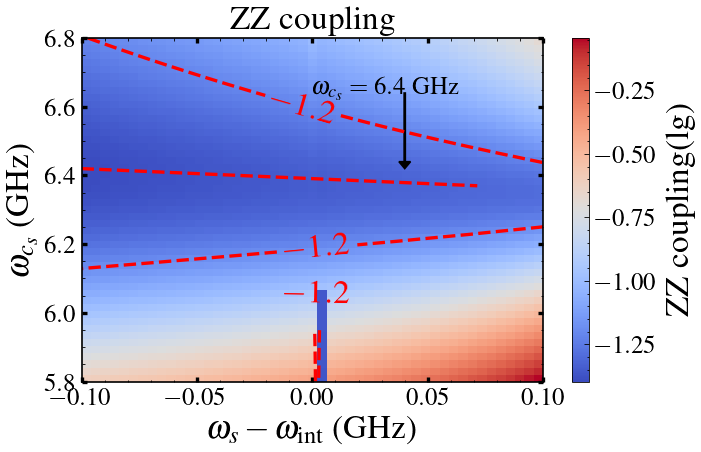

In [10]:
w3_list = np.linspace(-0.1, 0.1, 50)
wc_list = np.linspace(5.8, 6.8, 50)
X, Y = np.meshgrid(w3_list, wc_list)
fig, ax = plt.subplots(figsize=(6, 4))
norm = mpl.colors.LogNorm()
c = ax.pcolormesh(X,
                  Y,
                  np.log10(np.abs(zz.T) * 1e3),
                  cmap='coolwarm')

cb = plt.colorbar(c, ax=ax)
font = {'size': 20}
cb.set_label(rf'ZZ coupling(lg)', fontdict=font)
ax.set_xlabel(r'$\omega_{s} - \omega_\text{int}$ (GHz)', fontdict=font)
ax.set_ylabel(r'$\omega_{c_{s}}$ (GHz)', fontdict=font)

# 画一个箭头：从点(0.5, 0.5)指向点(0.2, 0.2)
ax.arrow(4.64 - chip_b.q_dic['Q1']['w_idle'], 6.6401, 0, -0.2, head_width=0.005, head_length=0.02, fc='k', ec='k', width=0.0005)

# 在箭尾添加文字
ax.text(4.6 - chip_b.q_dic['Q1']['w_idle'], 6.6401, r'$\omega_{c_{s}}=6.4$ GHz', style='italic', fontsize=15)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='both', which='major', width=2)  # 主刻度

cb.ax.tick_params(labelsize=15)
spines = ax.spines

# 设置四个边框线的宽度
for spine in spines.values():
    spine.set_linewidth(1.)  # 设置线宽为2

CS = ax.contour(X, Y, np.log10(np.abs(zz.T) * 1e3), levels=[-1.2], colors='red', linewidths=2, linestyles='dashed')
ax.clabel(CS, inline=True, fontsize=20)
ax.set_title(r'ZZ coupling', fontdict=font)
# plt.hlines(y=6.4, xmin=w3_list[0], xmax=w3_list[-8], colors='red', linestyles='dashed')
plt.plot([w3_list[0], w3_list[-8]], [6.42, 6.37], color='red', linewidth=2, linestyle='dashed')
plt.tight_layout()
output_path = Path.cwd() / 'figures' / "zz.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')

In [44]:
bit_name_list = ['Q2', 'C1_2']
width = 40

# cz.fidelity_optimize(bit_name_list, width, w0_list=[4.519362614783559, 4.8886699367859645])
cz_b.fidelity_optimize(bit_name_list, width)

{'Q2': {'w_idle': 4.834873102612081}}
{'C1_2': {'w_idle': 5.253798816647614}}
{'Q2': 4.823181468097361, 'C1_2': 5.253798816647614}
{'Q2': 4.823181468097361, 'C1_2': 5.253798816647614} 0.056595822844714094
{'Q2': 4.873181468097361, 'C1_2': 5.253798816647614} 0.2371736516553532
{'Q2': 4.823181468097361, 'C1_2': 5.453798816647614} 0.39486403007733684
{'Q2': 4.87318146809736, 'C1_2': 5.053798816647614} 0.005177494438796559
{'Q2': 4.873181468097361, 'C1_2': 5.053798816647614} 0.005114849359984519
{'Q2': 4.82318146809736, 'C1_2': 5.053798816647614} 0.3046253583270737
{'Q2': 4.8606814680973605, 'C1_2': 5.203798816647614} 0.19031175622083263
{'Q2': 4.83568146809736, 'C1_2': 5.103798816647613} 0.1746807283372125
{'Q2': 4.841931468097361, 'C1_2': 5.128798816647613} 0.15039125003523224
{'Q2': 4.85443146809736, 'C1_2': 5.178798816647614} 0.1662658798226817
{'Q2': 4.8450564680973605, 'C1_2': 5.1412988166476135} 0.15466186423317152
{'Q2': 4.84818146809736, 'C1_2': 5.153798816647614} 0.15008388923912

({'Q2': 4.873181468097361, 'C1_2': 5.053798816647614}, 0.005114849359984519)

In [11]:
paras_best_b = {'Q2': 4.873181468097361, 'C1_2': 5.053798816647614}

In [12]:
width = 40
ws_list = np.linspace(4.6 - 0.1, 4.6 + 0.1, 40)
wc_list = np.linspace(5.8, 6.8, 40)

w_list = [
    list(item) for item in product([paras_best_b['Q2']], [paras_best_b['C1_2']],
                                ws_list, wc_list)
]

f_list = qp.parallel_map(cz_b.fidelity_calculate,
                            w_list,
                            task_kwargs={
                                'bit_name_list': ['Q2', 'C1_2', 'Q3', 'C2_3'],
                                'width': width,
                            },
                            progress_bar=True)


10.0%. Run time:  57.21s. Est. time left: 00:00:08:34
20.0%. Run time: 107.83s. Est. time left: 00:00:07:11
30.0%. Run time: 157.65s. Est. time left: 00:00:06:07
40.0%. Run time: 207.70s. Est. time left: 00:00:05:11
50.0%. Run time: 257.73s. Est. time left: 00:00:04:17
60.0%. Run time: 307.61s. Est. time left: 00:00:03:25
70.0%. Run time: 358.09s. Est. time left: 00:00:02:33
80.0%. Run time: 407.72s. Est. time left: 00:00:01:41
90.0%. Run time: 458.57s. Est. time left: 00:00:00:50
100.0%. Run time: 508.13s. Est. time left: 00:00:00:00
Total run time: 508.27s


C:\Users\KUSANA~1\AppData\Local\Temp/ipykernel_9776/2054010261.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax0.pcolormesh(X,


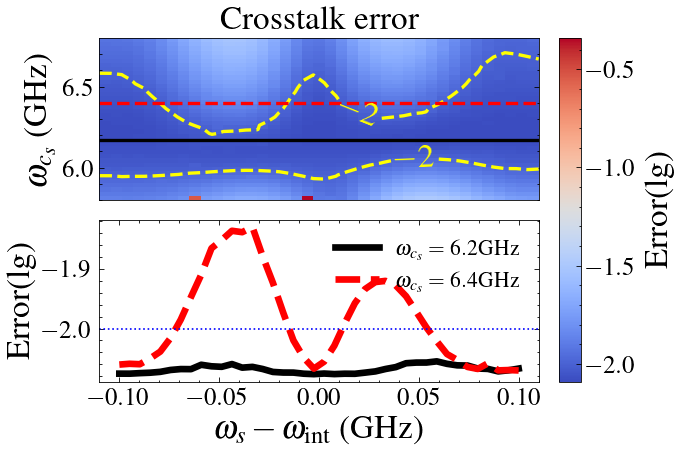

In [13]:
ws_list = np.linspace(-0.1, 0.1, 40)
wc_list = np.linspace(5.8, 6.8, 40)

error_arr = np.array(f_list).reshape(len(ws_list), len(wc_list))

for i, _ in enumerate(error_arr):
    # 使用find_peaks函数找到峰值的索引和属性
    peaks, properties = find_peaks(error_arr[i], width=0)

    # 设置宽度的阈值w，比如10
    w = 5

    # 找到宽度小于w的峰值的索引
    narrow_peaks = peaks[properties["widths"] < w]

    # 把属于峰值的值变成其周围值的平均，得到一个新的信号
    error_arr_new = error_arr[i].copy() # 复制原始信号，避免修改原始数据
    for p in narrow_peaks: # 遍历每个峰值的索引
        # 找到峰值的左右邻居的索引，注意边界情况
        left = max(0, p - 1)
        right = min(len(error_arr[i]) - 1, p + 1)
        # 计算峰值的左右邻居的平均值
        mean = (error_arr[i][left] + error_arr[i][right]) / 2
        # 用平均值替换峰值的值
        error_arr_new[p] = mean
    error_arr[i] = error_arr_new #- np.min(error_arr_new)

X, Y = np.meshgrid(ws_list, wc_list)
# 创建一个包含两个子图和colorbar的gridspec
fig = plt.figure(figsize=(6, 4))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 0.05])

# 在gridspec中放置子图
ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[1, 0])

# 在gridspec中放置colorbar
cax = plt.subplot(gs[:, 1])

error_arr = error_arr.T * 1.7

# 绘制热图
norm = mpl.colors.LogNorm()
c = ax0.pcolormesh(X,
                  Y,
                  np.log10(error_arr),
                  cmap='coolwarm')
cb = plt.colorbar(c, cax=cax)
font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 20}
cb.set_label(rf'Error(lg)', fontdict=font)
cb.ax.tick_params(labelsize=15)
ax0.set_ylabel(r'$\omega_{c_{s}}$ (GHz)', fontdict=font)

ax0.tick_params(axis='x', labelsize=15)
ax0.tick_params(axis='y', labelsize=15)

# 隐藏 axs[0] 的 x 轴标签
ax0.xaxis.set_visible(False)
ax0.set_title(r'Crosstalk error', fontdict=font)

CS = ax0.contour(X, Y, np.log10(error_arr), levels=[-2], colors='yellow', linewidths=2)  # 10 条等高线，黑色
ax0.clabel(CS, inline=True, fontsize=20)
ax0.set_title(r'Crosstalk error', fontdict=font)
ax0.hlines(y=6.17, xmin=ws_list[0], xmax=ws_list[-1], colors='black', linestyles='solid', linewidth=2)
ax0.hlines(y=6.4, xmin=ws_list[0], xmax=ws_list[-1], colors='red', linestyles='dashed', linewidth=2)

# 在 axs[1] 上绘制散点图和拟合曲线

offIndex = np.argmin(np.abs(wc_list - 6.1))
onIndex = np.argmin(np.abs(wc_list - 6.4))

ax1.plot(ws_list, np.log10(error_arr)[offIndex], label=r'$\omega_{c_{s}}=6.2$GHz')
ax1.plot(ws_list, np.log10(error_arr)[onIndex], label=r'$\omega_{c_{s}}=6.4$GHz')
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)

# 设置 axs[1] 的 x 轴标签
ax1.set_xlabel(r'$\omega_{s}-\omega_\text{int}$ (GHz)', fontdict=font)
ax1.set_ylabel(r'Error(lg)', fontdict=font)
ax1.axhline(-2, linestyle=':', color='blue', linewidth=1)#, label=r'$10^{-3}$')  

ax1.legend(fontsize=13, loc=1)

def format_func(value, tick_number):
    return f'{value:.3f}'


plt.tight_layout()
output_path = Path.cwd() / 'figures' / "heatxtalk.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')

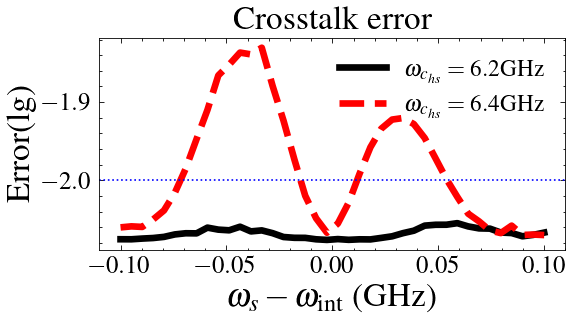

In [16]:
ws_list = np.linspace(-0.1, 0.1, 40)
wc_list = np.linspace(5.8, 6.8, 40)

error_arr = np.array(f_list).reshape(len(ws_list), len(wc_list))

for i, _ in enumerate(error_arr):
    # 使用find_peaks函数找到峰值的索引和属性
    peaks, properties = find_peaks(error_arr[i], width=0)

    # 设置宽度的阈值w，比如10
    w = 4

    # 找到宽度小于w的峰值的索引
    narrow_peaks = peaks[properties["widths"] < w]

    # 把属于峰值的值变成其周围值的平均，得到一个新的信号
    error_arr_new = error_arr[i].copy() # 复制原始信号，避免修改原始数据
    for p in narrow_peaks: # 遍历每个峰值的索引
        # 找到峰值的左右邻居的索引，注意边界情况
        left = max(0, p - 1)
        right = min(len(error_arr[i]) - 1, p + 1)
        # 计算峰值的左右邻居的平均值
        mean = (error_arr[i][left] + error_arr[i][right]) / 2
        # 用平均值替换峰值的值
        error_arr_new[p] = mean
    error_arr[i] = error_arr_new #- np.min(error_arr_new)



X, Y = np.meshgrid(ws_list, wc_list)
# 创建一个包含两个子图和colorbar的gridspec
_, ax = plt.subplots(figsize=(5, 2.9))

error_arr = error_arr.T * 1.7

# 在 axs[1] 上绘制散点图和拟合曲线

offIndex = np.argmin(np.abs(wc_list - 6.1))
onIndex = np.argmin(np.abs(wc_list - 6.4))

ax.plot(ws_list, np.log10(error_arr)[offIndex], label=r'$\omega_{c_{hs}}=6.2$GHz')
ax.plot(ws_list, np.log10(error_arr)[onIndex], label=r'$\omega_{c_{hs}}=6.4$GHz')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

# 设置 axs[1] 的 x 轴标签
ax.set_xlabel(r'$\omega_{s}-\omega_\text{int}$ (GHz)', fontdict=font)
ax.set_ylabel(r'Error(lg)', fontdict=font)
ax.set_title(r'Crosstalk error', fontdict=font)
ax.axhline(-2, linestyle=':', color='blue', linewidth=1)#, label=r'$10^{-3}$')  
# ax.set_ylim([-3, -1])

ax.legend(fontsize=14)

def format_func(value, tick_number):
    return f'{value:.3f}'

plt.tight_layout()
output_path = Path.cwd() / 'figures' / "crosstalk_error.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')

In [20]:
popt = np.array([4.6 - 0.04, 4.6 + 0.03, 5.55])
f1, f2, wc = popt.tolist()
t = np.linspace(0, 20, 1000)
ws_list = np.linspace(4.6 - 0.1, 4.6 + 0.1, 40)
X, Y = np.meshgrid(ws_list, t)
theory = double_rabi(cz_b, paras_best_b, f1, f2, wc, X, Y)


4.561538461538461
4.633333333333333


C:\Users\KUSANA~1\AppData\Local\Temp/ipykernel_9776/1594148250.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax2.plot((ws_list - 4.6) * 1e3, maxLeakage, 'r--', color='pink', label=r'$p_{110}$')


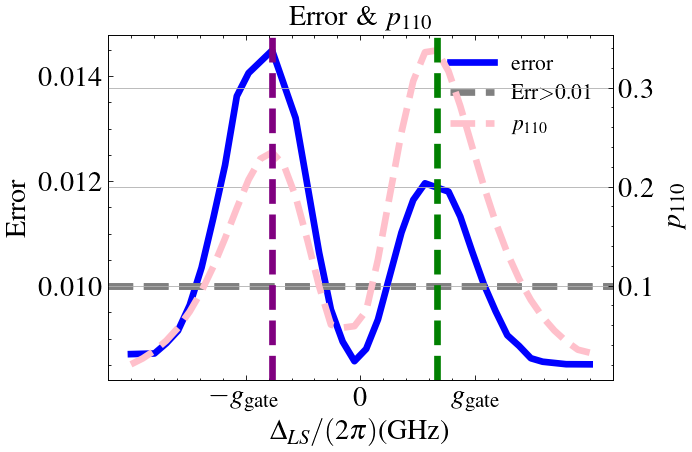

In [24]:
o_list = copy.deepcopy(f_list)
o_theory = copy.deepcopy(theory)
maxLeakage = np.max(o_theory, axis=0)
ws_list = np.linspace(4.6 - 0.1, 4.6 + 0.1, 40)
f_listi = (np.array(o_list).reshape(len(ws_list), len(wc_list)).T)[np.argmin(np.abs(wc_list - 6.4))]
# print(maxLeakage, f_listi)
# 使用find_peaks函数找到峰值的索引和属性
peaks, properties = find_peaks(f_listi, width=0)

# 设置宽度的阈值w，比如10
w = 10

# 找到宽度小于w的峰值的索引
narrow_peaks = peaks[properties["widths"] < w]

# 把属于峰值的值变成其周围值的平均，得到一个新的信号
error_arr_new = f_listi.copy() # 复制原始信号，避免修改原始数据
for p in narrow_peaks: # 遍历每个峰值的索引
    # 找到峰值的左右邻居的索引，注意边界情况
    left = max(0, p - 1)
    right = min(len(f_listi) - 1, p + 1)
    # 计算峰值的左右邻居的平均值
    mean = (f_listi[left] + f_listi[right]) / 2
    # 用平均值替换峰值的值
    error_arr_new[p] = mean
f_listi = error_arr_new

fig, ax1 = plt.subplots()

# font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 17}
font = {'weight': 'bold', 'size': 17}

# 创建第一个y轴
# Customize x-axis ticks
x_ticks = [-50, 0, 50]  # Set the desired x-ticks in MHz
x_labels = [r'$-g_\text{gate}$', r'$0$', r'$g_\text{gate}$']  # Set the corresponding labels
ax1.set_xticks(x_ticks)  # Set the x-ticks at the specified positions
ax1.set_xticklabels(x_labels, fontsize=17)  # Set the labels with a custom font size
ax1.plot((ws_list - 4.6) * 1e3, f_listi * 1.7, 'b-', label='error')
ax1.set_xlabel(r'$\Delta_{LS}/(2\pi)$(GHz)', fontdict=font)
# ax1.semilogy()
ax1.set_ylabel(r'Error', fontdict=font)

ax1.axhline(y=0.01, linestyle='--', color='gray', label=r'Err$>$0.01')
ax1.axhline(y=0.01, linestyle='--', color='gray')

omegas1 = np.argmax(f_listi)
print(ws_list[omegas1])

# 创建第二个y轴
ax2 = ax1.twinx()
ax2.plot((ws_list - 4.6) * 1e3, maxLeakage, 'r--', color='pink', label=r'$p_{110}$')
ax2.set_ylabel(r'$p_{110}$', fontdict=font)
omegas2 = np.argmax(maxLeakage)
ax2.axvline(x=(ws_list[omegas1] - 4.6) * 1e3, linestyle='--', color='purple')
ax2.axvline(x=(ws_list[omegas2] - 4.6) * 1e3, linestyle='--', color='green')
print(ws_list[omegas2])

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=13)
ax1.set_title(r'Error \& $p_{110}$', fontdict=font)


# ax1.tick_params(axis='x', labelsize=15, bottom=False, labelbottom=False)
ax1.tick_params(axis='x', labelsize=17)
ax1.tick_params(axis='y', labelsize=17)
ax2.tick_params(axis='y', labelsize=17)

plt.grid(True)
plt.tight_layout()
output_path = Path.cwd() / 'figures' / "errandleakage.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')


In [34]:
ws_list = [4.557142857142857, 4.630612244897959]
# ws_list = [4.29]
wc_list = np.linspace(6, 7, 50)
width = 200

gate_num = 7

arg_dic_list_b = [{
    **paras_best,
    **{
        'Q3': ws,
        'C2_3': wc
    }
} for ws, wc in product(ws_list, wc_list)]

evolution_result_list = qp.parallel_map(
    cz.run_evolution,
    arg_dic_list_b,
    task_kwargs={'parallel_args': ['arg_dic'],
                'width': width,
                'gate_num': 1,
                'init_state': (1, 1, 0)},
    progress_bar=True,
    num_cpus=cz.num_cpus)

10.0%. Run time:  13.19s. Est. time left: 00:00:01:58
20.0%. Run time:  16.36s. Est. time left: 00:00:01:05
30.0%. Run time:  23.74s. Est. time left: 00:00:00:55
40.0%. Run time:  26.64s. Est. time left: 00:00:00:39
50.0%. Run time:  33.92s. Est. time left: 00:00:00:33
60.0%. Run time:  38.84s. Est. time left: 00:00:00:25
70.0%. Run time:  43.94s. Est. time left: 00:00:00:18
80.0%. Run time:  50.17s. Est. time left: 00:00:00:12
90.0%. Run time:  54.42s. Est. time left: 00:00:00:06
100.0%. Run time:  57.72s. Est. time left: 00:00:00:00
Total run time:  57.86s


In [18]:
expec_name = '011'

mea_ops = cz.Od(('Q1', 'Q2', 'Q3'), (0, 1, 1))

evo_result_list = [
    np.max(qp.expect(mea_ops, evolution_result.states)) for evolution_result in evolution_result_list
]


In [19]:
# ws_list = [4.55, 4.64]
ws_list = [4.26]
expect_arr = np.array(evo_result_list).reshape(len(ws_list), len(wc_list))
ws_list = np.linspace(4.26 - 0.12, 4.26 + 0.12, 50)
# error_arr_two = np.vstack((error_arr.T[np.argmin(np.abs(ws_list - 4.55))], error_arr.T[np.argmin(np.abs(ws_list - 4.64))]))
error_arr_two = error_arr.T[np.argmin(np.abs(ws_list - 4.26))]
zzi = zz[np.argmin(np.abs(ws_list - 4.26))]

In [20]:
ws = 4.28
wc_list = np.linspace(6, 7, 50)
# g1, g2 = g_calculation(cz_b, paras_best_b, ws_list, wc_list, 4.2486398, 4.304337)
g1, g2 = g_calculation(cz, paras_best, ws_list, wc_list, 4.34, 4.43)

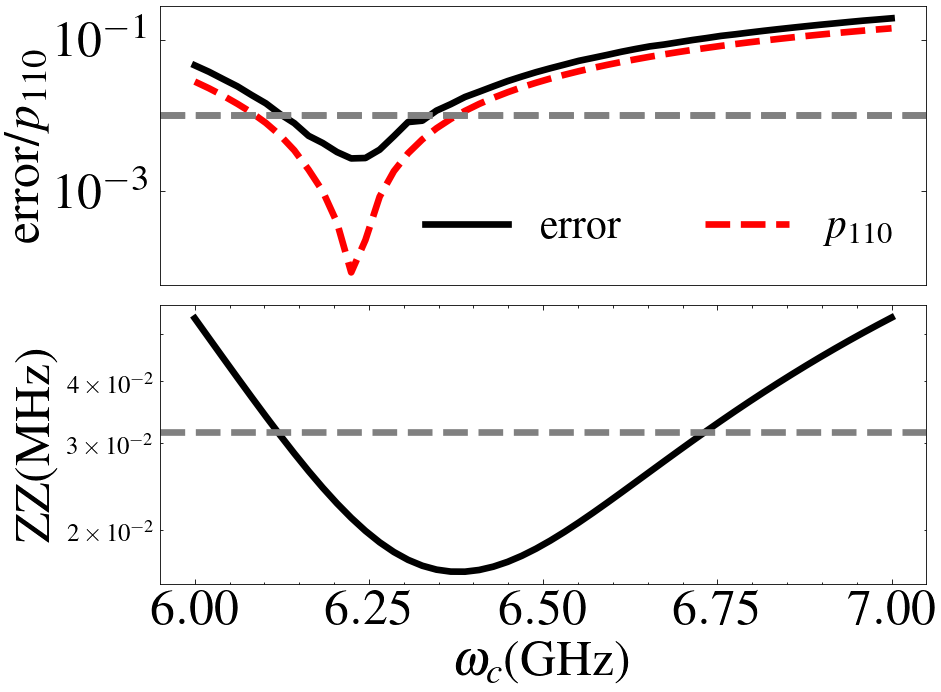

In [32]:
wc_list = np.linspace(6, 7, 50)
 
fig = plt.figure(figsize=(8, 6))

# 在画板上创建第一个子图，位置为1行3列的第1列
ax1 = fig.add_subplot(2, 1, 1)
# 在第一个子图上绘制y1随x的变化
# ax1.plot(wc_list, error_arr_two[0], label=r'error at $|+\rangle$')
# ax1.plot(wc_list, error_arr_two[1], label=r'error at $|-\rangle$')
ax1.plot(wc_list, np.abs(error_arr_two), label=r'error')
ax1.axhline(y=1e-2, linestyle='--', color='gray')
ax1.set_ylabel(r'error/$p_{110}$', fontsize=30)
# ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=30)
# ax1.legend(fontsize=10, fancybox=True, shadow=True, ncol=2)
# omegac = np.argmin(error_arr_two[0])
# ax1.annotate('err minimum', 
            # xy=(wc_list[omegac] + 0.05, np.min(error_arr_two[0])), xytext=(wc_list[omegac], np.min(error_arr_two[0]) + 0.005),
            # arrowprops={'arrowstyle': '->'}, fontsize=15)
ax1.semilogy()
# 设置第一个子图的标题
# ax1.set_title('(a)', fontsize=30)
ax1.xaxis.set_visible(False)

# 在画板上创建第二个子图，位置为1行3列的第2列
# 在第二个子图上绘制y2随x的变化
ax1.plot(wc_list, expect_arr[0], label=r'$p_{110}$')
# ax1.plot(wc_list, expect_arr[1], label=r'$|-\rangle$' + 'to' + r'$|110\rangle$')
# ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=30)
ax1.axhline(y=1e-2, linestyle='--', color='gray')
# ax1.set_ylabel('leakage', fontsize=18)
ax1.legend(fontsize=25, fancybox=True, shadow=True, ncol=2)
omegac = np.argmin(expect_arr[0])
# ax1.annotate('leakage minimum', 
            # xy=(wc_list[omegac] + 0.1, np.min(expect_arr[0]) + 0.0001), xytext=(wc_list[omegac] + 0.4, np.min(expect_arr[0])),
            # arrowprops={'arrowstyle': '->'}, fontsize=15)
ax1.semilogy()
# 设置第二个子图的标题
ax1.xaxis.set_visible(False)

# axtwin = ax1.twinx()
# font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 20}
# axtwin.set_ylabel('g(MHz)',  fontdict=font)
# axtwin.set_yscale('log')
# custom_color = ploter.cmap(np.linspace(0, 1, 9))
# axtwin.plot(wc_list, g2 * 1e3, linestyle='-', label='geff 1', color=custom_color[0])
# handles1, labels1 = ax1.get_legend_handles_labels()
# handles2, labels2 = axtwin.get_legend_handles_labels()
# ax1.legend(handles1 + handles2, labels1 + labels2, loc=4, fontsize=15)

# 在画板上创建第三个子图，位置为1行3列的第3列
ax3 = fig.add_subplot(2, 1, 2)
# 在第三个子图上绘制y3随x的变化
ax3.plot(wc_list, zzi)
ax3.axhline(y=10 ** (-1.5), linestyle='--', color='gray')
ax3.set_xlabel(r'$\omega_c$' + '(GHz)', fontsize=30)
ax3.set_ylabel('ZZ(MHz)', fontsize=30)
ax3.tick_params(axis='x', labelsize=30)
ax3.tick_params(axis='y', labelsize=30)
ax3.semilogy()
omegac = np.argmin(zzi)
# ax3.annotate('zz coupling minimum', 
            # xy=(wc_list[omegac], np.min(zzi)), xytext=(wc_list[omegac], np.min(zzi) + 0.06),
            # arrowprops={'arrowstyle': '->'}, fontsize=18)
# 设置第三个子图的标题
# ax3.set_title('(b)', fontsize=30)
# 调整子图之间的间距
plt.tight_layout()
# 显示画板
# ploter.save_fig(fig, rf'leakageerror.pdf', flag_save=True)
plt.savefig(os.path.join(fig_path, rf'leakage.pdf'))

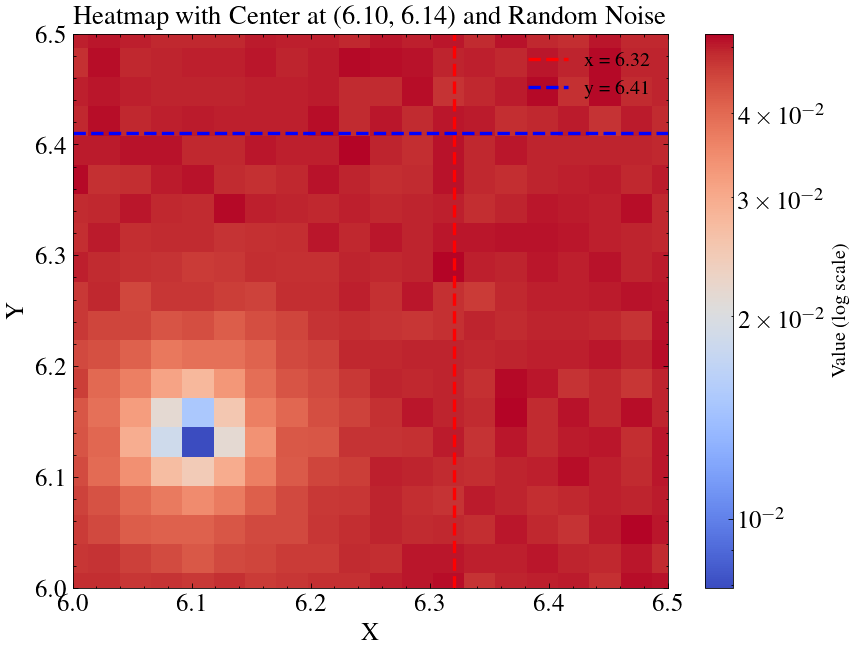

In [11]:
# 定义坐标范围
x = np.linspace(6, 6.5, 20)
y = np.linspace(6, 6.5, 20)

# 生成网格
X, Y = np.meshgrid(x, y)

# 定义中心点
center_x, center_y = 6.10, 6.14

# 计算每个点到中心点的距离
distance = np.sqrt((X - center_x)**2 + (Y - center_y)**2)

# 定义值的计算方式
# 在中心点附近的值小于 10^{-3}，随着距离增加，值逐渐增大，但增长更加平缓
Z = 0.05 * (1 - np.exp(-distance / 0.05))  # 调整分母使增长更平缓

# 增加随机性
# 在 Z 值中加入一些随机噪声，噪声的幅度可以根据需要调整
noise = np.random.normal(0, 0.001, Z.shape)  # 均值为 0，标准差为 0.001 的随机噪声
Z += noise

# 确保 Z 的最小值为一个很小的正数，避免对数刻度出现问题
Z = np.maximum(Z, 1e-5)

# 绘制热力图
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, Z, shading='auto', cmap='coolwarm', norm=LogNorm(vmin=Z.min(), vmax=Z.max()))  # 使用对数刻度
cbar = plt.colorbar(label='Value (log scale)')  # 添加颜色条，并标注为对数刻度
cbar.set_label('Value (log scale)', fontsize=12)  # 设置颜色条标签

# 添加竖直线和横线
plt.axvline(x=6.32, color='red', linestyle='--', linewidth=2, label='x = 6.32')  # 竖直线
plt.axhline(y=6.41, color='blue', linestyle='--', linewidth=2, label='y = 6.41')  # 横线

# 添加图例
plt.legend()

plt.title('Heatmap with Center at (6.10, 6.14) and Random Noise')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(6, 6.5)
plt.ylim(6, 6.5)
plt.show()